# Total RMSE for performance assessment of ARPEGE-Climat PPE

<a id="top">This code</a> is combining the metric of four different variables (tas, pr, SW, LW) to create an aggretated metric $E_{tot}$ used for performance assessment and seleciton of an optimal sub-set of parametrizations. 

### [Step 1 - Emulator skill evaluation](#skill)
### [Figure histograms](#histograms)
### [Step 2 - Initial guess for optimization 1 ](#init1)
### [Step 3 - Optimisation 1 ](#optim1)
### [Step 4 - Initial guess for Optimization 2 (param. smoothing)](#init2)
### [Step 5 - Optimisation 2](#optim2)
### [Step 6 - Optimal subset of parameters](#selection)
### [Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3](#validation)
### [Step 8  - Feedback likelihood](#likelihood)
### [Step 9  - Parameter analysis](#param)

## Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

## Functions

In [2]:
N_error = 128*256
path_file_npy = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy'
path_file_txt = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt'

In [3]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

def RMSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = sqrt(diff_tmp.sum(['lat', 'lon']))
    return diff

def RMSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_eof_2D, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = RMSE(mod, obs, W_rmse_2D)
    return diff

In [4]:
def function_E_var(pc_mod, variable):
    ## -- Mean and weights 
    Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
    Mean = Mean[0,:,:].rename({'variable':'mode'})
    W_eof_2D = np.load(path_file_npy+'/W_eof_2D_'+variable+'.npy')
    W_rmse_2D = np.load(path_file_npy+'/W_rmse_2D_'+variable+'.npy')
                         
    ## -- eofs_combined
    eofs=[]
    for i in range(1,6,1) :
        eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
        eofs.append(eof_tmp)
    eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
    
    ## -- U_obs
    if variable == 'tas' :
        U_obs = np.load(path_file_npy+'/U_obs_'+variable+'_BEST.npy')
    else :
        U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    
    ## -- X_rec_obs
    X_rec_obs = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2)
    
    ## -- X_rec_mod 
    X_rec_mod = reconstruct_X(eofs_combined, pc=pc_mod, nb_dims=2)
    
    ## -- RMSE _rec 
    E = RMSE_rec(X_rec_mod, X_rec_obs, Mean, W_eof_2D, W_rmse_2D)
    
    return E

In [5]:
# FONCTION MOYENNE NORMALISEE DES VARIABLES

def Norm_Average_df(Fdbck, variables, E_p1_df, name) :

    E_df = pd.DataFrame()
    E_df['Fdbck'] = Fdbck

    tmp = [0]*len(E_df) 

    for i in variables :
        E = np.load(path_file_npy+'/'+name+'_'+i+'.npy')
        E_df['RMSE_'+i] = E

        E_df['RMSE_'+i+'_norm'] = E_df['RMSE_'+i]/E_p1_df['E_p1_'+i]

        tmp = tmp + E_df['RMSE_'+i+'_norm']
    
    E_df['RMSE_total'] = tmp/len(variables)
    return E_df

In [6]:
def MultiLinReg_RMSE_skill_eval(limit_train, x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def function_RMSE_emulator_std_skill_eval(limit_train, x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_RMSE_skill_eval(limit_train,x, 1, variable)
    pc2 = MultiLinReg_RMSE_skill_eval(limit_train,x, 2, variable)
    pc3 = MultiLinReg_RMSE_skill_eval(limit_train,x, 3, variable)
    pc4 = MultiLinReg_RMSE_skill_eval(limit_train,x, 4, variable)
    pc5 = MultiLinReg_RMSE_skill_eval(limit_train,x, 5, variable)
    
    pc_mod = [pc1, pc2, pc3, pc4, pc5]
    E = function_E_var(pc_mod, variable)
    
    return E

def function_RMSE_total_skill_eval(limit_train, x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator_std_skill_eval(limit_train, x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E

In [7]:
# FONCTIONS FEEDBACKS

def em_fdb_std_skill_eval(limit_train, x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [8]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file=path_file_npy+"/X_EmulateurFeedbacksN.npy")
    y = np.load(file=path_file_npy+"/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file=path_file_npy+"/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save(path_file_npy+'/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save(path_file_npy+'/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [9]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 

    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    pc_mod = [pc1, pc2, pc3, pc4, pc5]
    E = function_E_var(pc_mod, variable)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

def function_RMSE_total(x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator(x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E
    

In [10]:
# -- FONCTION JACOBIAN 

def jacobian(x, variable) :
    
    ## -- Mean and weights 
    Mean =  pd.read_pickle(path_file_npy+'/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
    Mean = Mean[0,:,:].rename({'variable':'mode'})
    W_eof_2D = np.load(path_file_npy+'/W_eof_2D_'+variable+'.npy')
    W_rmse_2D = np.load(path_file_npy+'/W_rmse_2D_'+variable+'.npy')
                         
    ## -- eofs_combined
    eofs=[]
    for i in range(1,6,1) :
        eof_tmp = pd.read_pickle(path_file_npy+'/PPE2_EOFmap'+str(i)+'_'+variable+'.npy').to_xarray().to_array()
        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
        eofs.append(eof_tmp)
    eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
    
    ## -- U_obs
    if variable == 'tas' :
        U_obs = np.load(path_file_npy+'/U_obs_'+variable+'_BEST.npy')
    else :
        U_obs = np.load(path_file_npy+'/U_obs_'+variable+'.npy')
    
    ## -- X_rec_obs
    X_rec_obs = reconstruct_X(eofs_combined, pc=U_obs, nb_dims=2)
    
    
    ## -- Settings
    
    Beta1 = np.load(path_file_npy+'/Beta1.npy')
    Beta2 = np.load(path_file_npy+'/Beta2.npy')
    Beta3 = np.load(path_file_npy+'/Beta3.npy')
    Beta4 = np.load(path_file_npy+'/Beta4.npy')
    Beta5 = np.load(path_file_npy+'/Beta5.npy')
    
    MEAN = np.load(path_file_npy+'/LHS100000_mean.npy')
    STD = np.load(path_file_npy+'/LHS100000_std.npy')
    
    nb_dims = 2 
    
    ## -- A = RMSE_rec
    A = function_RMSE_emulator(x, variable)

    ## -- B = Sigma(2*(X_mod - X_rec_obs))
    toto = x - MEAN
    x_std = toto/STD
    
    pc1 = MultiLinReg_pred(x_std, 1, variable)
    pc2 = MultiLinReg_pred(x_std, 2, variable)
    pc3 = MultiLinReg_pred(x_std, 3, variable)
    pc4 = MultiLinReg_pred(x_std, 4, variable)
    pc5 = MultiLinReg_pred(x_std, 5, variable)
    
    pc = [pc1, pc2, pc3, pc4, pc5]
    X_mod = reconstruct_X(eofs_combined, pc, nb_dims)
    
    add =  X_mod - X_rec_obs
    tmp = 2*eofs_combined*add
    B = tmp.sum(['lat', 'lon'])
    
    ## C = Beta*eofs_combined
    pc_beta = []
    for i in range(0, len(Beta1), 1) :
        tmp = ([Beta1[i], Beta2[i], Beta3[i], Beta4[i], Beta5[i]])
        pc_beta.append(tmp)
    C = xr.DataArray(pc_beta, dims = ['param', 'eofs'])
    
    ## -- jac = 1/(2*A) * B * C
    tmp1 = 1/(2*float(A)) 
    tmp2 = np.dot(C, B)
    jac = np.dot(tmp1, tmp2)
    
    return jac

In [11]:
# FONCTION JACOBIAN OF TOTAL ERROR

def jacobian_total(x, variables, E_p1_df) :
    
    tmp = 0
    for i in variables : 
        tmp0 = jacobian(x, i)/E_p1_df['E_p1_'+i]
        tmp = tmp + tmp0
    
    jac = tmp/len(variables)
    
    return jac

In [12]:
# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [13]:

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variables, E_p1_df) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_total(x0, variables, E_p1_df)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_total,  x0, args=(variables, E_p1_df), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian_total, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_total(sol.x, variables, E_p1_df)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [14]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

## Settings

In [15]:
variables = ['tas', 'pr', 'SW', 'LW']

variable_plot = 'total'
TITLE = 'Total'
ylabel = '$E_{tot}$ (no units)'

product = 'BEST'

## Get the data

### p1 default

In [16]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df = {}

for i in variables :
    E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+i+'.npy')
    E_p1_df['E_p1_'+i] = E_p1

E_p1_df

{'E_p1_tas': array(0.83594254),
 'E_p1_pr': array(0.71881207),
 'E_p1_SW': array(8.18129142),
 'E_p1_LW': array(4.32785714)}

In [17]:
p1_feedbacks

array(-1.3328964)

In [18]:
E_p1_tmp = E_p1_df['E_p1_tas']/E_p1_df['E_p1_tas'] + E_p1_df['E_p1_pr']/E_p1_df['E_p1_pr'] + E_p1_df['E_p1_SW']/E_p1_df['E_p1_SW']+E_p1_df['E_p1_LW']/E_p1_df['E_p1_LW']
E_p1 = E_p1_tmp/4
E_p1

1.0

### CFMIP

In [19]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

MRI = {}
CAN = {}
MIROC = {}
HadGEM3 = {}
IPSL = {}
BCC = {}

for i in variables :
    
    variable = i
    
    filename = 'U_MRI_'+i+'.npy'
    pc_mod = np.load(path+filename)
    MRI[i] = function_E_var(pc_mod, variable)

    filename = 'U_CAN_'+i+'.npy'
    pc_mod = np.load(path+filename)
    CAN[i] = function_E_var(pc_mod, variable)

    filename = 'U_MIROC_'+i+'.npy'
    pc_mod = np.load(path+filename)
    MIROC[i] = function_E_var(pc_mod, variable)

    filename = 'U_HadGEM3_'+i+'.npy'
    pc_mod = np.load(path+filename)
    HadGEM3[i] = function_E_var(pc_mod, variable)

    filename = 'U_IPSL_'+i+'.npy'
    pc_mod = np.load(path+filename)
    IPSL[i] = function_E_var(pc_mod, variable)

    filename = 'U_BCC_'+i+'.npy'
    pc_mod = np.load(path+filename)
    BCC[i] = function_E_var(pc_mod, variable)
    

E_MRI_tmp = MRI['tas']/E_p1_df['E_p1_tas'] + MRI['pr']/E_p1_df['E_p1_pr'] + MRI['SW']/E_p1_df['E_p1_SW']+MRI['LW']/E_p1_df['E_p1_LW']
E_MRI = E_MRI_tmp/4

E_CAN_tmp = CAN['tas']/E_p1_df['E_p1_tas'] + CAN['pr']/E_p1_df['E_p1_pr'] + CAN['SW']/E_p1_df['E_p1_SW']+CAN['LW']/E_p1_df['E_p1_LW']
E_CAN = E_CAN_tmp/4

E_MIROC_tmp = MIROC['tas']/E_p1_df['E_p1_tas'] + MIROC['pr']/E_p1_df['E_p1_pr'] + MIROC['SW']/E_p1_df['E_p1_SW']+MIROC['LW']/E_p1_df['E_p1_LW']
E_MIROC = E_MIROC_tmp/4

E_HadGEM3_tmp = HadGEM3['tas']/E_p1_df['E_p1_tas'] + HadGEM3['pr']/E_p1_df['E_p1_pr'] + HadGEM3['SW']/E_p1_df['E_p1_SW']+HadGEM3['LW']/E_p1_df['E_p1_LW']
E_HadGEM3 = E_HadGEM3_tmp/4

E_IPSL_tmp = IPSL['tas']/E_p1_df['E_p1_tas'] + IPSL['pr']/E_p1_df['E_p1_pr'] + IPSL['SW']/E_p1_df['E_p1_SW']+IPSL['LW']/E_p1_df['E_p1_LW']
E_IPSL = E_IPSL_tmp/4

E_BCC_tmp = BCC['tas']/E_p1_df['E_p1_tas'] + BCC['pr']/E_p1_df['E_p1_pr'] + BCC['SW']/E_p1_df['E_p1_SW']+BCC['LW']/E_p1_df['E_p1_LW']
E_BCC = E_BCC_tmp/4

In [20]:
E_CFMIP = [float(E_MRI), float(E_CAN), float(E_MIROC), float(E_HadGEM3), 
           float(E_IPSL), float(E_BCC), float(E_p1)]
E_CFMIP

[0.4389613111718527,
 0.42240441255555183,
 1.7351773886874007,
 0.8850584437952689,
 1.2462154528839195,
 0.8833898492771262,
 1.0]

In [21]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [22]:
sigma_CFMIP = std(E_CFMIP)
sigma_CFMIP

0.4233715191633756

### PPE

In [23]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

name = 'RMSE_PPE'
E_PPE_df = Norm_Average_df(Fdbck_PPE, variables, E_p1_df, name) 
E_PPE_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-0.825236,0.647210,0.774228,1.714906,2.385750,27.756642,3.392697,8.517303,1.968019,2.130173
1,-1.659636,1.252261,1.498022,1.442550,2.006853,12.577989,1.537409,8.872889,2.050181,1.773116
2,-1.215000,1.525514,1.824903,1.469045,2.043713,8.773974,1.072444,12.656512,2.924429,1.966372
3,-1.321641,1.219729,1.459106,1.895091,2.636420,13.905584,1.699681,11.049263,2.553056,2.087066
4,-0.750397,1.029800,1.231903,1.255031,1.745979,14.813880,1.810702,7.824954,1.808044,1.649157
...,...,...,...,...,...,...,...,...,...,...
97,-1.516367,1.514234,1.811409,1.675025,2.330268,14.947696,1.827058,8.173671,1.888618,1.964338
98,-1.584491,1.324151,1.584021,0.839152,1.167415,9.332918,1.140763,7.961097,1.839501,1.432925
99,-1.474525,1.112730,1.331108,1.036647,1.442167,9.195344,1.123948,6.553689,1.514303,1.352882
100,-1.445422,1.769182,2.116391,1.054332,1.466771,13.354620,1.632336,8.360200,1.931718,1.786804


In [24]:
E_PPE = E_PPE_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable_plot+'.npy', E_PPE)

### Multi Lin Reg predictions

In [25]:
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
name = 'RMSE_multilinreg_pred'

E_multilinreg_df = Norm_Average_df(Fdbck_multilinreg_pred, variables, E_p1_df, name) 
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.499698,0.800449,0.957540,1.226157,1.705810,4.312227,0.527084,5.624554,1.299616,1.122513
1,-1.339351,0.790974,0.946206,1.148225,1.597393,11.596800,1.417478,7.002656,1.618042,1.394780
2,-1.323732,0.973920,1.165057,1.302973,1.812675,13.563705,1.657893,7.386396,1.706710,1.585584
3,-1.541909,1.410387,1.687182,1.523161,2.118998,9.675836,1.182678,11.645459,2.690814,1.919918
4,-1.346961,0.621249,0.743172,1.307891,1.819518,9.771319,1.194349,6.059144,1.400033,1.289268
...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,0.936806,1.120658,1.124317,1.564132,14.598154,1.784334,7.915299,1.828919,1.574511
99996,-1.410350,1.289788,1.542915,1.474320,2.051051,16.115265,1.969770,7.335934,1.695050,1.814696
99997,-1.296397,0.941951,1.126813,1.095821,1.524489,12.940145,1.581675,6.876754,1.588951,1.455482
99998,-1.299809,1.455038,1.740596,0.900739,1.253093,15.087888,1.844194,5.588856,1.291368,1.532313


In [26]:
E_multilinreg = E_multilinreg_df['RMSE_total'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable_plot+'.npy', E_multilinreg)

### [Back to the top](#top)

# <a id="skill">Step 1 - Emulator skill evaluation</a> </li>

In [87]:
variables = ['tas', 'pr', 'SW', 'LW']
variable = 'total'

In [93]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

RMSE_skill_eval = []
for i in X :
    tmp = function_RMSE_total_skill_eval(80, i, variables, E_p1_df)
    RMSE_skill_eval.append(tmp)

Validation_RMSE_df = pd.DataFrame()
Validation_RMSE_df['RMSE_PPE_total'] = E_PPE_df['RMSE_'+variable]
Validation_RMSE_df['RMSE_multilinreg_val_total'] = RMSE_skill_eval
Validation_RMSE_df

,RMSE_PPE_total,RMSE_multilinreg_val_total
0,2.130173,1.582191
1,1.773116,1.709887
2,1.966372,2.067386
3,2.087066,1.952901
4,1.649157,1.627933
...,...,...
97,1.964338,1.803996
98,1.432925,1.593415
99,1.352882,1.373077
100,1.786804,1.794368


In [94]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_multilinreg_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_Etot = sqrt(sum_diff/n)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_Etot)
OSE = OSE_Etot.round(2)
OSE

0.23

In [95]:
r_test = np.corrcoef(Test_set['RMSE_multilinreg_val_total'], Test_set['RMSE_PPE_total'])
r_test = r_test[0][1].round(2)
r_test

0.75

In [96]:
r_full = np.corrcoef(Validation_RMSE_df['RMSE_multilinreg_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_full = r_full[0][1].round(2)
r_full

0.85

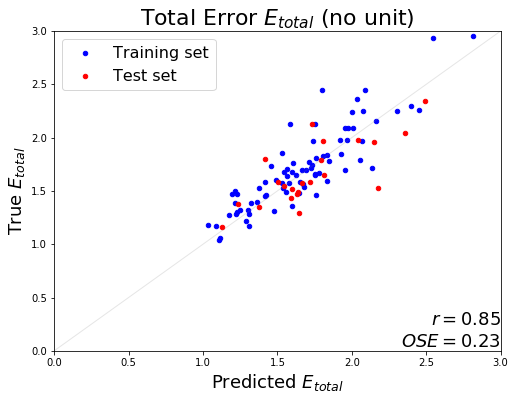

In [97]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{"+variable+"}$ (no unit)"
Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = '+str(OSE)+'$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = '+str(r_full)+'$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $E_{'+variable+'}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{'+variable+'}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,3)
plt.xlim(0,3)
ax.plot((0, 40), (0, 40), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [98]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

Fdbck_skill_eval = []
for i in X :
    tmp = em_fdb_std_skill_eval(80, i)
    Fdbck_skill_eval.append(tmp)

Validation_fdbck_df = pd.DataFrame()
Validation_fdbck_df['Fdbck_PPE'] = E_PPE_df['Fdbck']
Validation_fdbck_df['Fdbck_multilinreg_val'] = Fdbck_skill_eval
Validation_fdbck_df

,Fdbck_PPE,Fdbck_multilinreg_val
0,-0.825236,-1.180536
1,-1.659636,-1.594507
2,-1.215000,-1.068508
3,-1.321641,-1.363567
4,-0.750397,-1.140111
...,...,...
97,-1.516367,-1.550227
98,-1.584491,-1.635200
99,-1.474525,-1.418686
100,-1.445422,-1.621942


In [97]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_multilinreg_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_fdbck = sqrt(sum_diff/n)
OSE_fdbck

0.18506045695913942

In [98]:
r_test = np.corrcoef(Test_set_fdbck['Fdbck_multilinreg_val'], Test_set_fdbck['Fdbck_PPE'])
r_test

array([[1.        , 0.48017716],
       [0.48017716, 1.        ]])

In [43]:
r_full = np.corrcoef(Validation_fdbck_df['Fdbck_multilinreg_val'], Validation_fdbck_df['Fdbck_PPE'])
r_full

array([[1.       , 0.7259311],
       [0.7259311, 1.       ]])

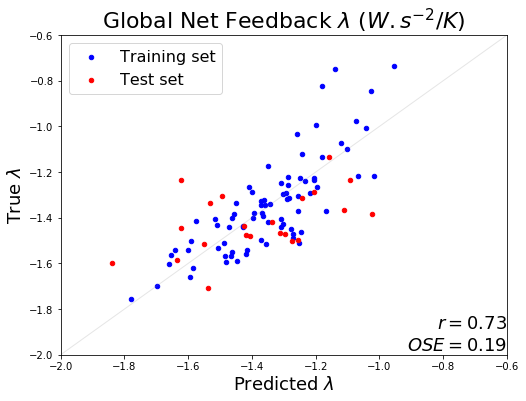

In [44]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.07,r'$r = 0.73$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.6)
plt.xlim(-2.0,-0.6)
ax.plot((-2.0,-0.6), (-2.0,-0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [45]:
E_p1 = np.load(path_file_npy+'/E_p1_'+variable_plot+'.npy')
p1_feedback = np.load(path_file_npy+'/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file=path_file_npy+'/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file=path_file_npy+"/Net_feedbacks.npy")

In [46]:
E_MLR = np.load(path_file_npy+'/RMSE_multilinreg_pred_'+variable_plot+'.npy')
Fdbck_MLR = np.load(file=path_file_npy+"/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [47]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.103096,0.779925
1,-1.064409,0.993931
2,-1.029369,0.994030
3,-1.276465,0.902121
4,-1.198514,0.838546
...,...,...
1161,-1.239931,0.884948
1162,-1.320968,0.935984
1163,-1.248014,0.850005
1164,-1.432138,0.989718


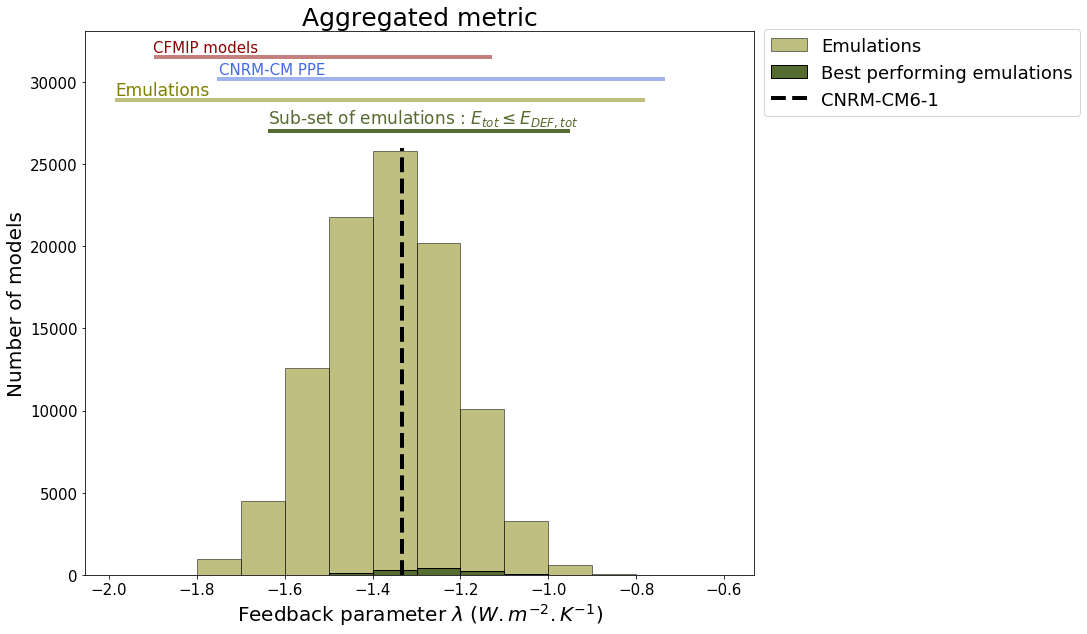

In [48]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{tot}\leq E_{DEF,tot}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [49]:
pourc = 100*len(MLR_short)/len(Fdbck_MLR)
pourc

1.166

In [50]:
E_PPE = np.load(path_file_npy+'/RMSE_PPE_'+variable_plot+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [51]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


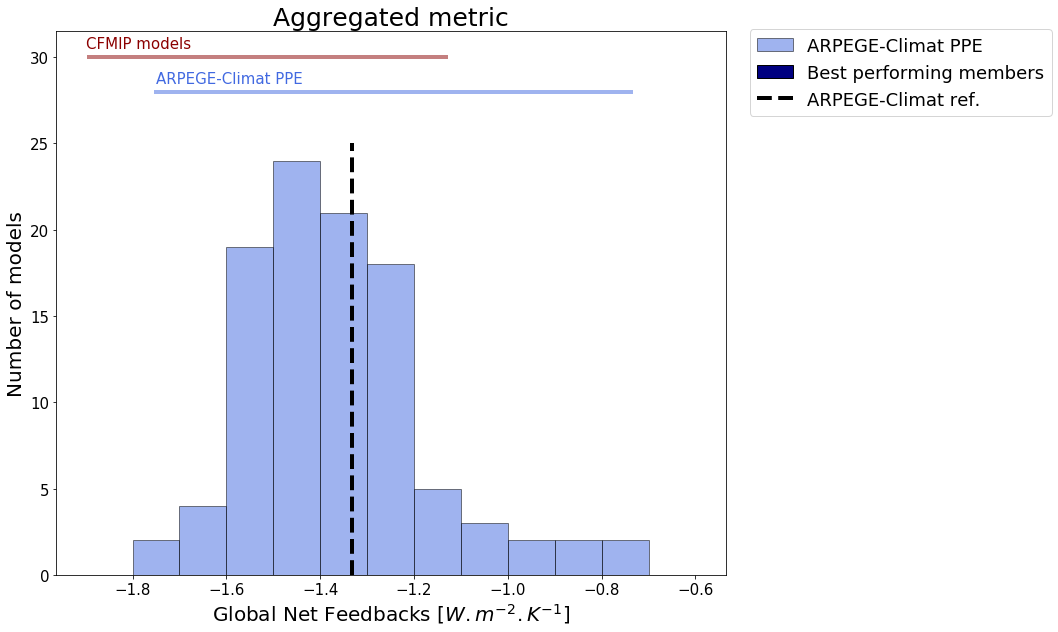

In [52]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'ARPEGE-Climat PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
#plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tot}\leq E_{DEF,tot}$', 
#         color = 'navy', fontsize=17)

legend=['ARPEGE-Climat PPE', 'Best performing members', 'ARPEGE-Climat ref.']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title('Aggregated metric', fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable_plot+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="init1">Step 2 - Initial guess for optimization 1</a> </li> 

In [26]:
E_multilinreg_df['Fdbck_round'] = E_multilinreg_df['Fdbck'].round(decimals=2)
E_multilinreg_df = E_multilinreg_df.set_index('Fdbck_round')
E_multilinreg_df['members'] = range(0,100000,1) 
E_multilinreg_df        

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,members
Fdbck_round,,,,,,,,,,,
-1.50,-1.499698,0.800449,0.957540,1.226157,1.705810,4.312227,0.527084,5.624554,1.299616,1.122513,0
-1.34,-1.339351,0.790974,0.946206,1.148225,1.597393,11.596800,1.417478,7.002656,1.618042,1.394780,1
-1.32,-1.323732,0.973920,1.165057,1.302973,1.812675,13.563705,1.657893,7.386396,1.706710,1.585584,2
-1.54,-1.541909,1.410387,1.687182,1.523161,2.118998,9.675836,1.182678,11.645459,2.690814,1.919918,3
-1.35,-1.346961,0.621249,0.743172,1.307891,1.819518,9.771319,1.194349,6.059144,1.400033,1.289268,4
...,...,...,...,...,...,...,...,...,...,...,...
-1.45,-1.453679,0.936806,1.120658,1.124317,1.564132,14.598154,1.784334,7.915299,1.828919,1.574511,99995
-1.41,-1.410350,1.289788,1.542915,1.474320,2.051051,16.115265,1.969770,7.335934,1.695050,1.814696,99996
-1.30,-1.296397,0.941951,1.126813,1.095821,1.524489,12.940145,1.581675,6.876754,1.588951,1.455482,99997


In [27]:
new_df=pd.DataFrame()
new_df['RMSE_total_best'] = E_multilinreg_df['RMSE_total'].groupby('Fdbck_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_round,RMSE_total_best
0,-1.99,1.978878
1,-1.95,2.207712
2,-1.93,2.595736
3,-1.91,2.983859
4,-1.90,1.869121
...,...,...
108,-0.86,1.502032
109,-0.85,1.818385
110,-0.82,2.614150
111,-0.80,2.478826


In [28]:
list_RMSE = new_df['RMSE_total_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_df['RMSE_total'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_df['Fdbck'].iloc[cpt])
            tmp_member.append(E_multilinreg_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_round,RMSE_total_best,Fdbck,members
0,-1.99,1.978878,-1.985956,35649
1,-1.95,2.207712,-1.953341,47523
2,-1.93,2.595736,-1.927200,30599
3,-1.91,2.983859,-1.914973,74150
4,-1.90,1.869121,-1.901409,94179
...,...,...,...,...
108,-0.86,1.502032,-0.860371,58900
109,-0.85,1.818385,-0.850213,95065
110,-0.82,2.614150,-0.820649,57260
111,-0.80,2.478826,-0.803475,76973


In [29]:
# CHECK OBJECTIVE FUNCTION

#x = x_best[4]
#y = function_RMSE_total(x, variables, E_p1_df)
#print(y)

### [Back to the top](#top)

# <a id="optim1">Step 3 - Optimization 1</a> </li> 

In [30]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [31]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
xlim

array([[ 6.0e-02,  2.8e-01],
       [ 5.0e-01,  3.0e+00],
       [ 5.0e-01,  3.0e+00],
       [ 0.0e+00,  3.0e+01],
       [-5.0e-01, -1.0e-02],
       [ 0.0e+00,  1.0e+01],
       [ 0.0e+00,  1.0e+01],
       [ 5.0e-04,  1.0e-02],
       [ 5.0e-05,  1.0e-03],
       [ 5.0e-04,  1.0e-02],
       [ 1.0e-08,  1.0e-06],
       [ 5.0e-06,  1.0e-04],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-03,  2.0e-01],
       [ 1.0e-01,  6.0e+00],
       [ 1.0e-01,  6.0e+00],
       [ 3.0e-05,  7.0e-05],
       [ 8.0e-05,  6.0e-04],
       [ 2.0e-06,  1.0e-05],
       [ 3.0e-05,  1.2e-04],
       [-5.0e+00, -1.0e+00],
       [-5.0e+01, -2.5e+01],
       [ 1.0e-02,  1.0e-01],
       [ 0.0e+00,  2.0e+01],
       [ 1.0e-05,  1.0e-04],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 5.0e-01,  1.0e+00],
       [ 2.0e-01,  1.0e+01]])

In [32]:
sol_df = Optimization(x_best, 0.0001, xlim, variables, E_p1_df)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9787045663932106
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.2071327707405484
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.5950122337270054
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.9733799538185086
            Iterations: 12
            Function evaluations: 78
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8689744839236149
            Iterations: 1
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9548861697086481
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9894909135302679
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.840203347653024
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9422332501473618
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9171470274655844
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7974786758479191
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7574252033880963
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8295568692571895
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7729754782581737
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7787024836165879
            Iterations: 1
            Function evaluat

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.978705,-1.985910,0.101215,0.935382,2.308133,29.837963,-0.079680,8.933799,3.065018,0.005121,...,-2.509268,-25.309487,0.074967,14.089720,0.000044,0.911281,0.653092,0.507047,0.534739,6.132503
1,2.207133,-1.953170,0.130365,0.518172,2.872093,18.860472,-0.088673,7.825258,5.734525,0.007950,...,-2.523141,-30.855336,0.097532,18.790066,0.000068,0.992155,0.731525,0.520490,0.787005,3.375163
2,2.595012,-1.927076,0.060067,0.673983,0.982857,27.137453,-0.070642,8.113609,1.745147,0.005570,...,-1.728656,-49.729025,0.094351,9.531735,0.000070,0.830593,0.892184,0.876023,0.500110,7.277910
3,2.973380,-1.912389,0.100783,0.843713,2.646472,18.486640,-0.452143,9.469305,0.678202,0.005511,...,-1.819494,-40.818792,0.088122,2.214680,0.000015,0.770401,0.884587,0.629639,0.627123,1.572822
4,1.868974,-1.901268,0.099845,0.747660,2.092827,20.515322,-0.371005,9.848770,0.375256,0.002001,...,-2.757172,-31.309796,0.084520,19.382021,0.000014,0.813069,0.725227,0.601387,0.654760,8.318389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.499275,-0.860707,0.215442,2.647613,1.929427,5.463446,-0.399419,2.738033,5.070339,0.008310,...,-1.433743,-44.340171,0.019697,7.638067,0.000031,0.641968,0.668066,0.822112,0.849828,9.797610
109,1.816177,-0.850632,0.220169,2.535767,1.201479,10.396413,-0.352586,1.356909,5.941171,0.002496,...,-1.917818,-47.175391,0.010701,1.993003,0.000017,0.554039,0.741603,0.732627,0.833628,2.835573
110,2.588385,-0.823164,0.227556,2.712325,0.597423,17.515973,-0.469767,0.363286,4.359941,0.002504,...,-1.154604,-25.762821,0.026297,1.320510,0.000098,0.661208,0.510832,0.993471,0.883253,1.639130
111,2.479013,-0.803655,0.268091,2.483245,1.733741,21.225144,-0.176523,0.270735,4.039712,0.006399,...,-2.846182,-44.714195,0.011913,5.214880,0.000068,0.901174,0.875119,0.604810,0.939932,1.337606


### Plotting

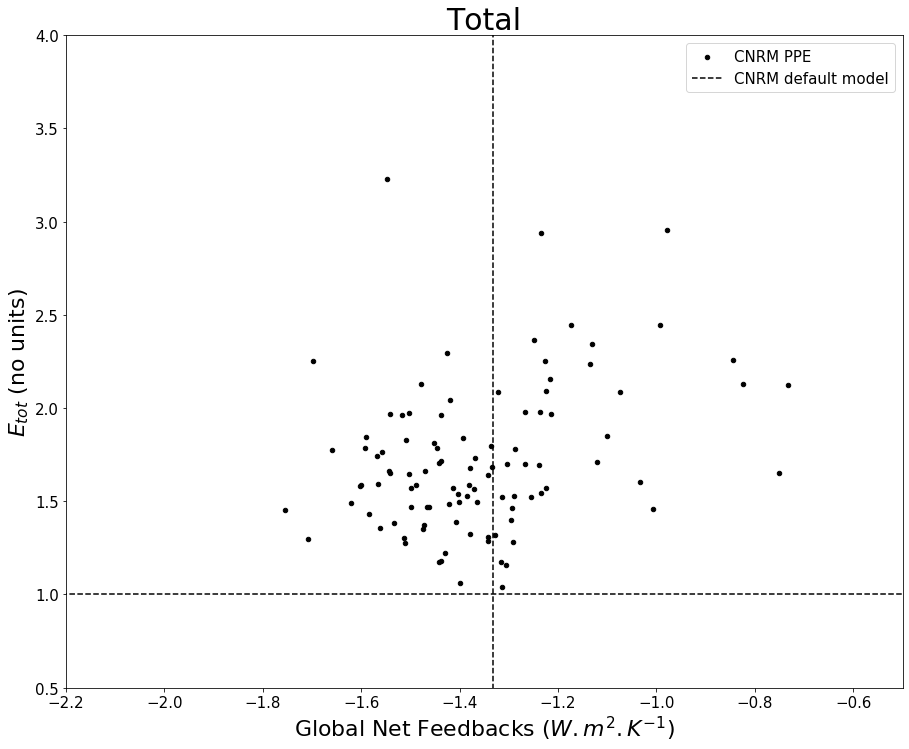

In [33]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_only.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

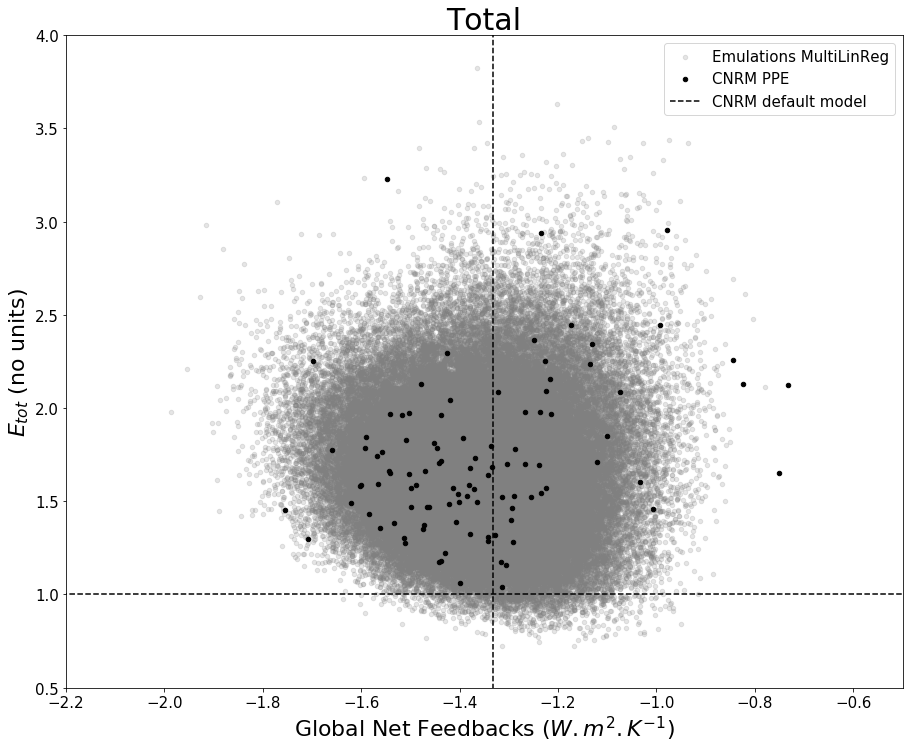

In [34]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

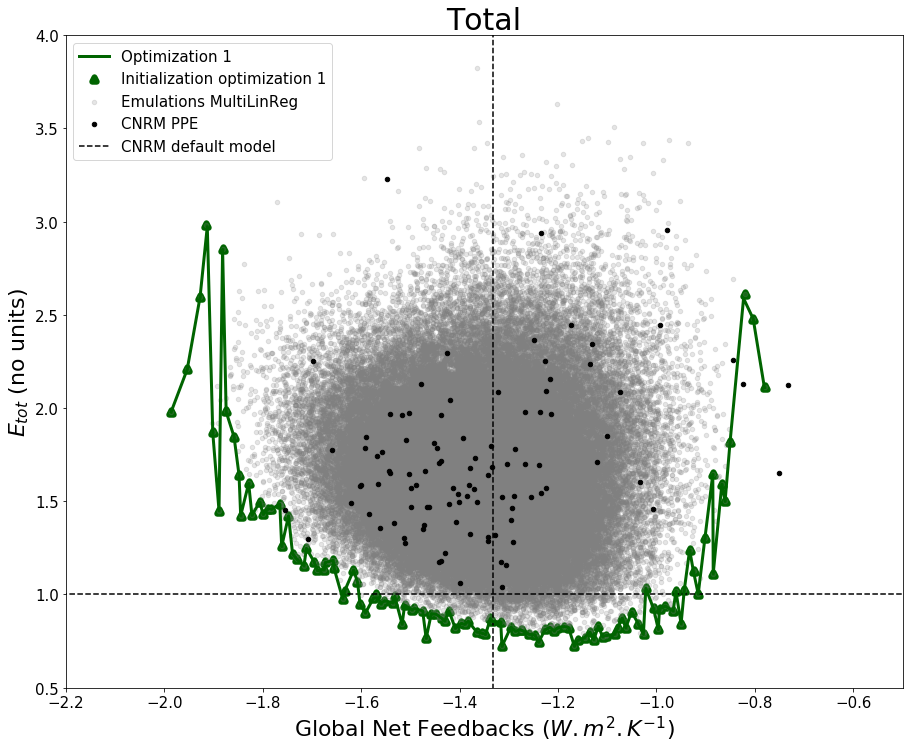

In [35]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

#  <a id="init2">Step 4 - Initial guess for Optimization 2 (param. smoothing)</a> </li> 

In [36]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985910,0.101215,0.935382,2.308133,29.837963,-0.079680,8.933799,3.065018,0.005121,0.000707,...,-2.509268,-25.309487,0.074967,14.089720,0.000044,0.911281,0.653092,0.507047,0.534739,6.132503
1,-1.953170,0.105503,0.661427,2.258794,23.674090,-0.081917,8.174481,4.069804,0.006648,0.000753,...,-2.549623,-26.039558,0.076352,14.001650,0.000045,0.903747,0.665994,0.523091,0.543155,5.981390
2,-1.927076,0.087820,0.677463,1.871070,22.905504,-0.170525,8.380445,2.475755,0.006150,0.000652,...,-2.589441,-26.757775,0.077712,13.912549,0.000046,0.896425,0.678756,0.539004,0.551501,5.832723
3,-1.912389,0.090369,0.777267,2.092157,21.156514,-0.336483,9.225247,0.869201,0.004648,0.000532,...,-2.628191,-27.452978,0.079018,13.821374,0.000047,0.889519,0.691243,0.554660,0.559712,5.688837
4,-1.901268,0.093020,0.856483,1.874375,19.040191,-0.324806,9.780519,2.598139,0.003323,0.000728,...,-2.665367,-28.115340,0.080249,13.727053,0.000047,0.883209,0.703326,0.569933,0.567724,5.551845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.860707,0.232615,2.544249,1.616199,8.888316,-0.411010,2.504784,5.781034,0.005929,0.000346,...,-2.575595,-45.067920,0.018214,7.167852,0.000046,0.571403,0.599417,0.892842,0.885538,6.629909
109,-0.850632,0.220834,2.607868,1.232452,10.943061,-0.393589,1.453784,5.328155,0.003952,0.000547,...,-2.561168,-45.622535,0.018182,7.713668,0.000045,0.560666,0.587173,0.913598,0.895405,6.912945
110,-0.823164,0.235843,2.610916,1.032516,16.663376,-0.367161,0.588554,4.675191,0.003476,0.000661,...,-2.545551,-46.197007,0.018150,8.277601,0.000044,0.549421,0.574571,0.935082,0.905541,7.204316
111,-0.803655,0.260184,2.604663,1.303475,22.334762,-0.314134,0.678542,4.673906,0.005767,0.000709,...,-2.529096,-46.785490,0.018119,8.853955,0.000043,0.537824,0.561725,0.957063,0.915861,7.501353


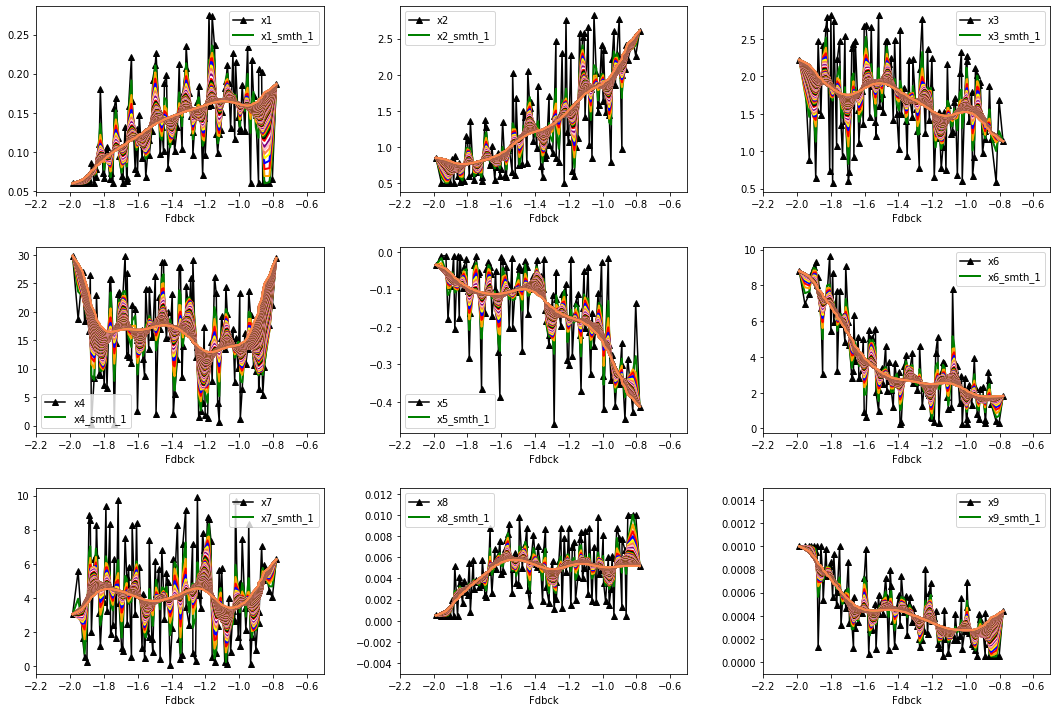

In [37]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

# <a id="optim2">Step 5 - Optimisation 2</a> </li> 

In [37]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.10121538, 0.93538244, 2.30813329, ..., 0.50704737, 0.53473932,
        6.13250284],
       [0.101931  , 0.93808081, 2.29043032, ..., 0.52309093, 0.54315468,
        5.98138973],
       [0.10266645, 0.94060344, 2.27265207, ..., 0.53900433, 0.55150127,
        5.8327232 ],
       ...,
       [0.2638239 , 2.61722666, 1.22020287, ..., 0.93508237, 0.90554071,
        7.20431641],
       [0.27038694, 2.67831582, 1.18476164, ..., 0.95706322, 0.91586116,
        7.50135267],
       [0.2769965 , 2.73983534, 1.14899735, ..., 0.97929567, 0.92627617,
        7.80125498]])

In [38]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_total(i, variables, E_p1_df)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985910,1.978705
1,-1.953170,1.934452
2,-1.927076,1.890868
3,-1.912389,1.847805
4,-1.901268,1.805136
...,...,...
108,-0.860707,1.678271
109,-0.850632,1.780877
110,-0.823164,1.887542
111,-0.803655,1.997392


In [39]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variables, E_p1_df)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9786499796191883
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.9343002796025268
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8906875018350526
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8476561399128708
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8047336687800748
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.873727814329575
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8629395238421785
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8532298447883083
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8434005305742701
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8334402923296296
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6934512792917978
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6947119163889741
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6968842680024507
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.699506813923222
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7032117398857869
            Iterations: 1
            Function evaluati

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.934300,-1.971665,0.101923,0.938328,2.290108,28.452721,-0.088391,8.812695,3.234051,0.005073,...,-2.549339,-26.039369,0.076355,14.002736,0.000045,0.903765,0.666056,0.523087,0.543147,5.980319
2,1.890688,-1.957551,0.102680,0.940761,2.272516,27.085657,-0.096932,8.693807,3.398839,0.005022,...,-2.589319,-26.757640,0.077713,13.913016,0.000046,0.896417,0.678766,0.539040,0.551536,5.832291
3,1.847656,-1.943524,0.103436,0.942923,2.254566,25.755345,-0.105087,8.573051,3.560103,0.004973,...,-2.628029,-27.452732,0.079016,13.821948,0.000047,0.889531,0.691275,0.554654,0.559706,5.688266
4,1.804734,-1.929515,0.104246,0.945437,2.235712,24.480462,-0.112664,8.448105,3.717275,0.004923,...,-2.664538,-28.113783,0.080253,13.730112,0.000047,0.883268,0.703476,0.569898,0.567690,5.549150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.677538,-0.835138,0.251033,2.497033,1.288496,23.511310,-0.392016,1.782295,5.319526,0.007066,...,-2.574742,-45.057061,0.018243,7.164023,0.000046,0.571366,0.599374,0.892900,0.885384,6.626445
109,1.778052,-0.822073,0.257232,2.554557,1.254177,24.881865,-0.402303,1.785273,5.539171,0.007239,...,-2.559205,-45.596600,0.018223,7.704046,0.000045,0.560593,0.587080,0.913689,0.894995,6.904529
110,1.884405,-0.808612,0.263653,2.615155,1.219543,26.338284,-0.412717,1.791978,5.772441,0.007417,...,-2.544069,-46.176296,0.018176,8.270878,0.000044,0.549477,0.574530,0.935129,0.905142,7.200580
111,1.972740,-0.797967,0.269891,2.650933,1.176321,27.507121,-0.420415,1.778796,5.940043,0.007548,...,-2.509903,-46.511473,0.018145,8.830086,0.000044,0.540922,0.561021,0.957529,0.910594,7.433596


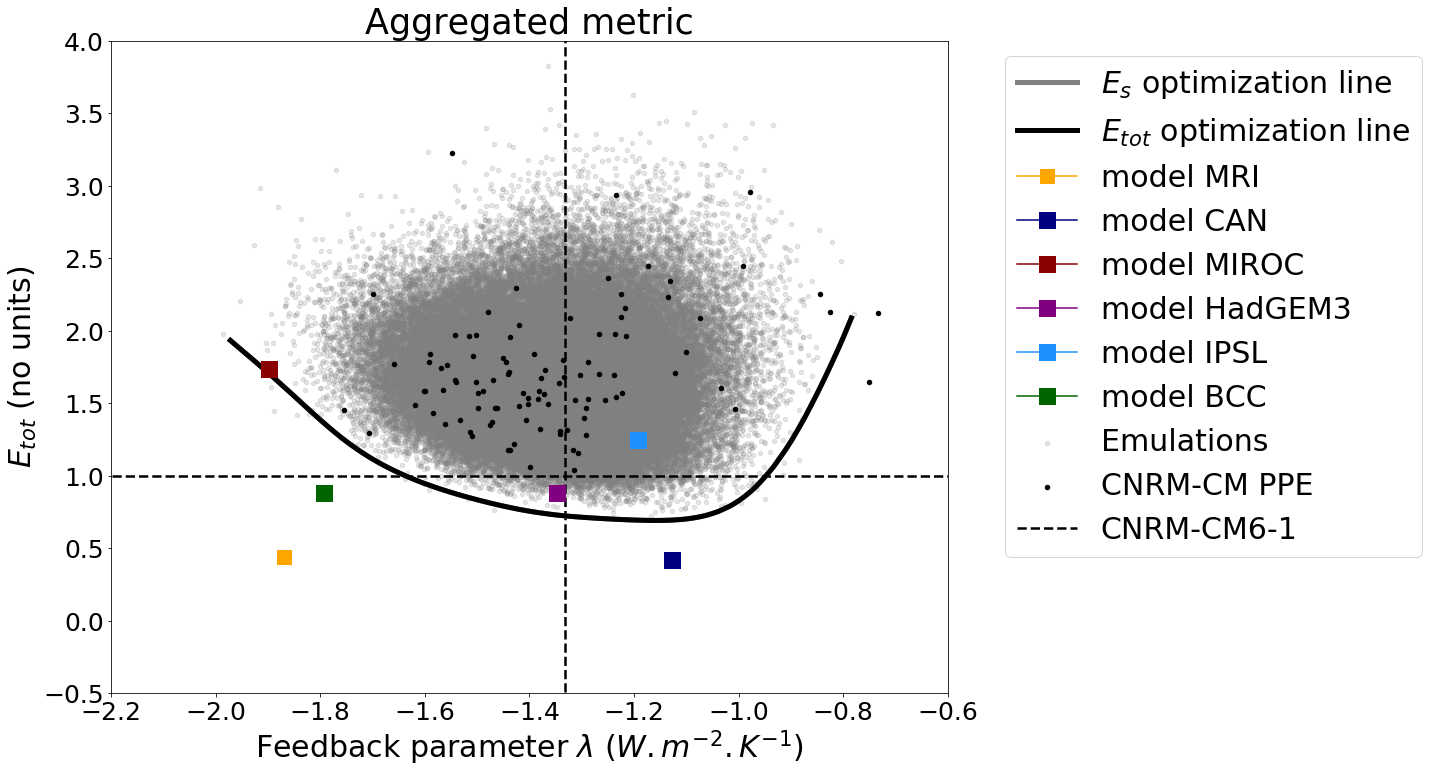

In [40]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{s}$ optimization line', '$E_{tot}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=30, bbox_to_anchor=(1.05, 1))

plt.title('Aggregated metric', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,4.0)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_main.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [41]:
RMSE_optim2 = sol_df_2#['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable_plot+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable_plot+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

In [42]:
df_select = sol_df_2[sol_df_2.index % 5 == 0]
df_select = df_select.append(sol_df_2.iloc[len(sol_df_2)-1])
df_select

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
5,1.762048,-1.915792,0.105226,0.946306,2.217400,23.271347,-0.119617,8.326439,3.862775,0.004866,...,-2.699887,-28.735554,0.081387,13.630740,0.000048,0.877644,0.714951,0.584855,0.575630,5.421690
10,1.554896,-1.851139,0.110753,0.941849,2.115372,18.630109,-0.141649,7.682224,4.433933,0.004578,...,-2.831352,-31.109435,0.084989,13.034519,0.000051,0.863447,0.762282,0.647811,0.608788,4.941525
15,1.365314,-1.793117,0.117653,0.925779,1.993968,16.535588,-0.144756,6.979020,4.723136,0.004277,...,-2.879095,-32.476790,0.084603,12.153954,0.000052,0.867025,0.789303,0.687230,0.631255,4.689734
20,1.210276,-1.739799,0.124279,0.914087,1.872786,16.160868,-0.139411,6.202231,4.822008,0.004093,...,-2.861966,-33.377190,0.081028,10.923123,0.000054,0.872076,0.799245,0.704418,0.642916,4.478891
25,1.092965,-1.688818,0.129353,0.916731,1.799238,16.227429,-0.133492,5.376256,4.795431,0.004196,...,-2.800839,-33.904028,0.076146,9.493748,0.000055,0.867365,0.798937,0.710677,0.646475,4.211288
30,1.002655,-1.638441,0.132807,0.937947,1.799551,16.191064,-0.127751,4.593259,4.620000,0.004596,...,-2.694675,-33.900412,0.071569,8.145789,0.000057,0.854647,0.792044,0.718739,0.648308,3.984981
35,0.931638,-1.588352,0.135540,0.988634,1.843533,16.185412,-0.119959,3.950301,4.326672,0.005104,...,-2.559700,-33.503864,0.067906,7.006633,0.000058,0.840374,0.777997,0.731503,0.656286,3.897473
40,0.873728,-1.538515,0.139184,1.073116,1.875451,16.454288,-0.109988,3.473790,4.068607,0.005482,...,-2.448508,-33.084557,0.064489,6.016906,0.000057,0.829561,0.758095,0.742957,0.673381,3.920094
45,0.824222,-1.488119,0.143873,1.170296,1.863909,16.803264,-0.101644,3.133087,3.975235,0.005613,...,-2.393045,-32.867850,0.060039,5.179393,0.000056,0.824722,0.736912,0.749706,0.694522,4.013213


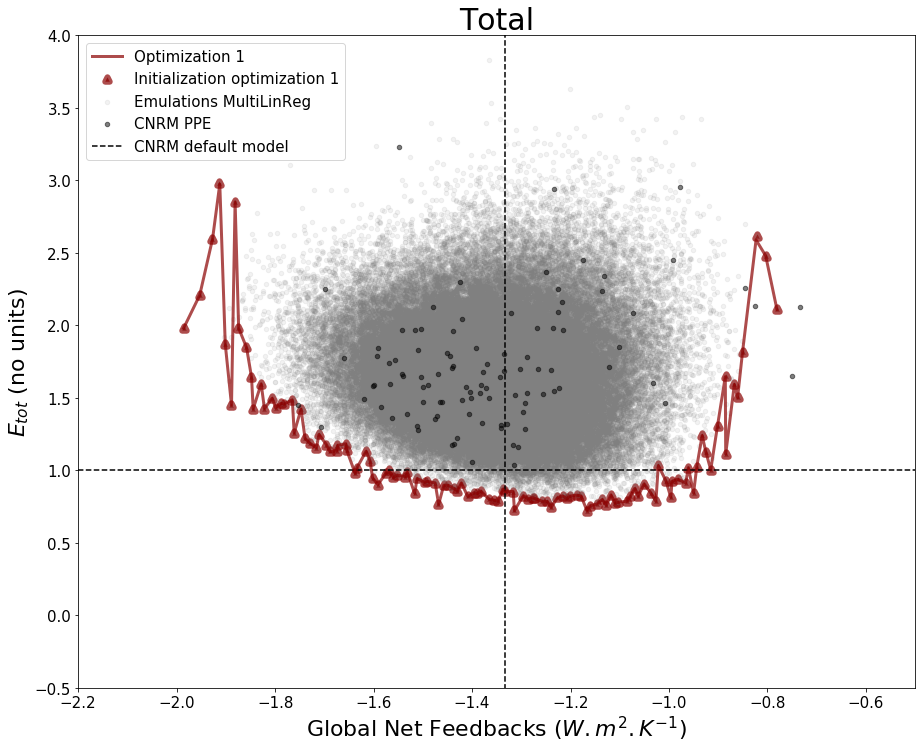

In [43]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.7,
         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
#         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.7,
         linewidth=3, ax = ax)

#sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

#df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
#               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Initialization optimization 1', 
                   'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

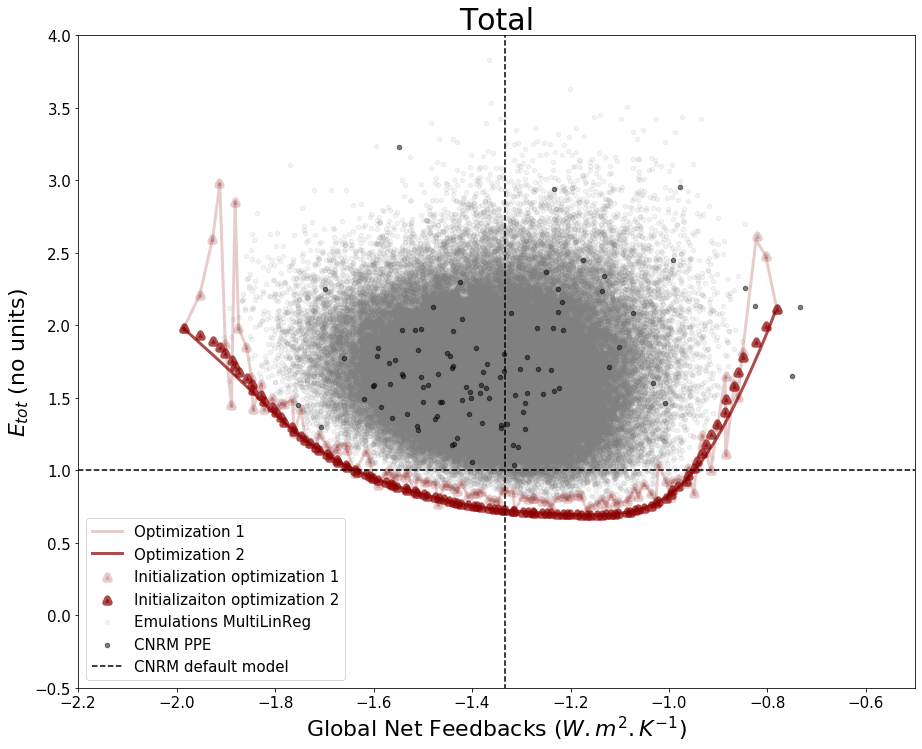

In [44]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.7,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.7, linewidth=3, ax = ax)

#df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
#               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

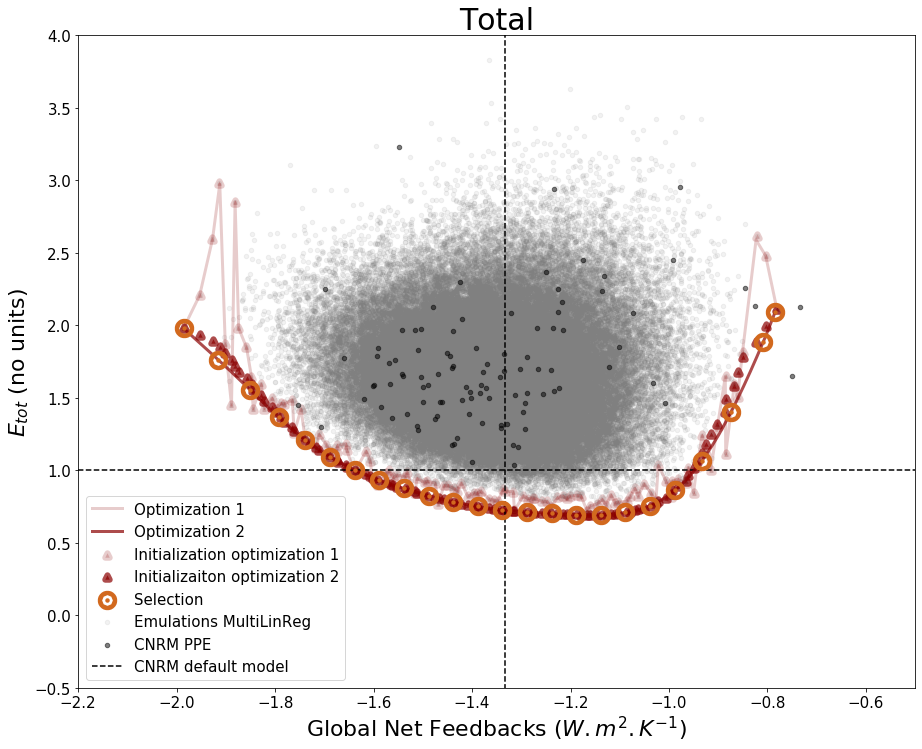

In [45]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.7,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.7, linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='chocolate', marker='o', linewidth=15, 
               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [46]:
list_index = df_select.columns.tolist()
list_index

['sol_fun',
 'Fdbck',
 'x1_smth_0',
 'x2_smth_0',
 'x3_smth_0',
 'x4_smth_0',
 'x5_smth_0',
 'x6_smth_0',
 'x7_smth_0',
 'x8_smth_0',
 'x9_smth_0',
 'x10_smth_0',
 'x11_smth_0',
 'x12_smth_0',
 'x13_smth_0',
 'x14_smth_0',
 'x15_smth_0',
 'x16_smth_0',
 'x17_smth_0',
 'x18_smth_0',
 'x19_smth_0',
 'x20_smth_0',
 'x21_smth_0',
 'x22_smth_0',
 'x23_smth_0',
 'x24_smth_0',
 'x25_smth_0',
 'x26_smth_0',
 'x27_smth_0',
 'x28_smth_0',
 'x29_smth_0',
 'x30_smth_0']

### Save the data

In [47]:
np.save(path_file_npy+'/RMSE_optim2_select2.npy', df_select)
np.save(path_file_npy+'/RMSE_optim2_select2_indexes.npy', list_index)
np.save(path_file_npy+'/RMSE_optim2_total.npy', sol_df_2)

In [48]:
df_select_tmp = df_select.drop(['sol_fun', 'Fdbck'], axis=1)
np.savetxt(path_file_txt+'/selection_SIX_optim2_param.txt', df_select_tmp.values)

#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_BIS_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_TER_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_QUAT_optim2_param.txt', df_select_tmp.values)

### [Back to the top](#top)

# <a id="validation">Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3</a> </li>

### Settings

In [27]:
nb_p_list_selection = ['p860', 'p861', 'p862', 'p864', 'p865', 'p866', 'p867', 'p868', 'p869', 
                    'p870', 'p871', 'p872', 'p873','p874', 'p875', 'p876', 'p877', 'p878', 'p879',
                    'p880', 'p881', 'p882', 'p883']
len(nb_p_list_selection)

23

In [28]:
file = np.load(path_file_npy+'/RMSE_optim2_select2.npy')
df_select = pd.DataFrame(file).drop([3])
df_select['sol_fun'] = df_select[0]
df_select['Fdbck'] = df_select[1]
df_select = df_select
#df_select

In [29]:
df_crashed = pd.DataFrame(file).drop([0,1,2,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 
                                      16,17,18, 19,20,21,22,23])
df_crashed['sol_fun']=df_crashed[0]
df_crashed['Fdbck']=df_crashed[1]
df_crashed

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
3,1.365314,-1.793117,0.117653,0.925779,1.993968,16.535588,-0.144756,6.97902,4.723136,0.004277,...,0.084603,12.153954,0.000052,0.867025,0.789303,0.68723,0.631255,4.689734,1.365314,-1.793117


In [30]:
RMSE_optim_line = np.load(path_file_npy+'/RMSE_optim2_'+variable_plot+'.npy')
Fdbck_optim_line = np.load(path_file_npy+'/Fdbck_optim2_'+variable_plot+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308,1.978650,-1.985892
1,1.934300,-1.971665,0.101923,0.938328,2.290108,28.452721,-0.088391,8.812695,3.234051,0.005073,...,0.076355,14.002736,0.000045,0.903765,0.666056,0.523087,0.543147,5.980319,1.934300,-1.971665
2,1.890688,-1.957551,0.102680,0.940761,2.272516,27.085657,-0.096932,8.693807,3.398839,0.005022,...,0.077713,13.913016,0.000046,0.896417,0.678766,0.539040,0.551536,5.832291,1.890688,-1.957551
3,1.847656,-1.943524,0.103436,0.942923,2.254566,25.755345,-0.105087,8.573051,3.560103,0.004973,...,0.079016,13.821948,0.000047,0.889531,0.691275,0.554654,0.559706,5.688266,1.847656,-1.943524
4,1.804734,-1.929515,0.104246,0.945437,2.235712,24.480462,-0.112664,8.448105,3.717275,0.004923,...,0.080253,13.730112,0.000047,0.883268,0.703476,0.569898,0.567690,5.549150,1.804734,-1.929515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.677538,-0.835138,0.251033,2.497033,1.288496,23.511310,-0.392016,1.782295,5.319526,0.007066,...,0.018243,7.164023,0.000046,0.571366,0.599374,0.892900,0.885384,6.626445,1.677538,-0.835138
109,1.778052,-0.822073,0.257232,2.554557,1.254177,24.881865,-0.402303,1.785273,5.539171,0.007239,...,0.018223,7.704046,0.000045,0.560593,0.587080,0.913689,0.894995,6.904529,1.778052,-0.822073
110,1.884405,-0.808612,0.263653,2.615155,1.219543,26.338284,-0.412717,1.791978,5.772441,0.007417,...,0.018176,8.270878,0.000044,0.549477,0.574530,0.935129,0.905142,7.200580,1.884405,-0.808612
111,1.972740,-0.797967,0.269891,2.650933,1.176321,27.507121,-0.420415,1.778796,5.940043,0.007548,...,0.018145,8.830086,0.000044,0.540922,0.561021,0.957529,0.910594,7.433596,1.972740,-0.797967


### Error estimate

In [31]:
PC_PPE_selection = {}

for j in variables :
    for i in nb_p_list_selection :
        PC_PPE_selection[i+'_'+j] = np.load(path_file_npy+'/U_'+i+'_'+j+'.npy')
    
#PC_PPE_selection

In [32]:
E_PPE_selection = {}

for var in variables :
    list_tmp = []
    for i in nb_p_list_selection :
        pc_mod = np.load(path_file_npy+'/U_'+i+'_'+var+'.npy')
        E =  function_E_var(pc_mod, var)
        list_tmp.append(E)

    E_PPE_selection[var] = list_tmp

#E_PPE_selection

In [33]:
E_p1_df

{'E_p1_tas': array(0.83594254),
 'E_p1_pr': array(0.71881207),
 'E_p1_SW': array(8.18129142),
 'E_p1_LW': array(4.32785714)}

In [34]:
E_PPE_selection_total=[0]*len(E_PPE_selection['tas'])

for i in range(0,len(E_PPE_selection['tas']),1) :
    E_PPE_selection_total[i] = E_PPE_selection['tas'][i]/E_p1_df['E_p1_tas']+E_PPE_selection['pr'][i]/E_p1_df['E_p1_pr']+E_PPE_selection['SW'][i]/E_p1_df['E_p1_SW']+E_PPE_selection['LW'][i]/E_p1_df['E_p1_LW']
    E_PPE_selection_total[i] = float(E_PPE_selection_total[i]/4)

E_PPE_selection_total

[1.8672500410158843,
 1.6828860533676204,
 1.5362922957202756,
 1.3334249889599832,
 1.2582207285055904,
 1.2328422140893298,
 1.1524537069473932,
 1.1384604761570571,
 1.1150746410028558,
 1.0778356774103783,
 1.0943070872045755,
 1.1088282164479366,
 1.1175819152423938,
 1.165149105265326,
 1.1810814454366174,
 1.253383032972582,
 1.2950786890614006,
 1.4263832282856226,
 1.6259669614281247,
 1.905626793621146,
 2.3047098506332535,
 2.679771752083938,
 2.8181112312332486]

In [35]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy'



Fdbck_PPE_selection = []
Fdbck_tmp = np.load(file=path+"/SIX_Net_feedbacks.npy").tolist()
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    

    
#Fdbck_PPE_selection

In [36]:
## -- Save data :
np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt/E_tot_selection.txt', 
           E_PPE_selection_total)
np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/txt/Fdbck_selection.txt', 
           Fdbck_PPE_selection)

## Interpolation between candidates - cubic spline

In [37]:
## -- Take Laurent's interpolation with NCL 
path = '/data/home/globc/peatier/CNRMppe_save/PPE/ENSEMBLE4_selection/files/txt/'
file = np.loadtxt(path+'Laurent_interp_spline.txt', delimiter=', ')
Inter_df = pd.DataFrame(file, columns=['Fdbck', 'Inter'])
Inter_df

,Fdbck,Inter
0,-1.70,1.8448
1,-1.69,1.7882
2,-1.68,1.7316
3,-1.67,1.6752
4,-1.66,1.6191
...,...,...
96,-0.74,1.5938
97,-0.73,1.6051
98,-0.72,1.6164
99,-0.71,1.6276


# <a id="likelihood">Likelihood - emulator</a> </li>

In [39]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

CFMIP_list = ['MRI', 'CAN', 'MIROC', 'HadGEM3', 'IPSL', 'BCC']

In [40]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df

{'E_p1_tas': array(0.83594254),
 'E_p1_pr': array(0.71881207),
 'E_p1_SW': array(8.18129142),
 'E_p1_LW': array(4.32785714)}

In [41]:
## -- Test avec OSE remplacé par la std des models CFMIP

Likelihood_df = pd.DataFrame()
variables = ['tas', 'pr', 'SW', 'LW']


RMSE_optim2={}
Fdbck_optim2={}
for var in variables : 
    RMSE_optim2[var] = np.load(path_file_npy+'/RMSE_optim2_'+var+'.npy')
    Fdbck_optim2[var] = np.load(path_file_npy+'/Fdbck_optim2_'+var+'.npy')
    OSE = np.load(path_file_npy+'/OSE_'+var+'.npy')
    std = np.std(RMSE_optim2[var])
    
    E_p1_tmp = E_p1_df['E_p1_'+var]
    L = []
    cpt=0
    for j in RMSE_optim2[var] :
        tmp = exp(-(j**2)/(2*((sigma_CFMIP+OSE)**2)))
        tmp_2 = tmp#/(sqrt(OSE))#*1/100
        cpt+=1
        L.append(tmp_2)


    Likelihood_df['Fdbck_'+var] = Fdbck_optim2[var]
    Likelihood_df['Fdbck_likelihood_'+var] = L
    
    scale = Likelihood_df['Fdbck_likelihood_'+var].max()
    like = []
    for k in Likelihood_df['Fdbck_likelihood_'+var] : 
        tmp = k/scale
        like.append(tmp)
    Likelihood_df['Fdbck_likelihood_'+var] = like
    
#Likelihood_df['Fdbck_likelihood_tas'][0] = Likelihood_df['Fdbck_likelihood_tas'][1]
Likelihood_df

,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW
0,-1.985872,0.174920,-1.985808,0.056017,-1.985956,1.272205e-08,-1.985956,1.094438e-10
1,-1.971651,0.189267,-1.971593,0.067692,-1.971433,7.824471e-08,-1.971744,7.582566e-10
2,-1.957459,0.204078,-1.957435,0.081152,-1.957609,4.039729e-07,-1.957583,4.735134e-09
3,-1.943310,0.220442,-1.943303,0.096307,-1.943564,1.900979e-06,-1.943522,2.667956e-08
4,-1.929458,0.237046,-1.929409,0.113647,-1.929669,7.904044e-06,-1.928571,1.495584e-07
...,...,...,...,...,...,...,...,...
108,-0.834792,0.565010,-0.843872,0.192425,-0.846192,3.834420e-09,-0.835718,1.390178e-05
109,-0.821432,0.519195,-0.831591,0.146480,-0.833600,1.061508e-10,-0.821188,3.574740e-06
110,-0.807986,0.471104,-0.836635,0.165825,-0.820102,2.036477e-12,-0.808404,9.857342e-07
111,-0.794438,0.421187,-0.820430,0.116196,-0.807140,2.828748e-14,-0.794096,2.178616e-07


In [42]:
i='total'
RMSE_optim2 = np.load(path_file_npy+'/RMSE_optim2_'+i+'.npy')
Fdbck_optim2 = np.load(path_file_npy+'/Fdbck_optim2_'+i+'.npy')

OSE = np.load(path_file_npy+'/OSE_total.npy')
std = np.std(RMSE_optim2.transpose()[0])
    
E_p1_tmp = E_p1
L = []
cpt=0
for j in RMSE_optim2.transpose()[0] :
    tmp =exp(-(j**2)/(2*((sigma_CFMIP+OSE)**2)))
    tmp_2 = tmp#/sqrt(OSE)*1/100
    L.append(tmp_2)
    cpt+=1


Likelihood_df['Fdbck_'+i] = Fdbck_optim2
Likelihood_df['Fdbck_likelihood_'+i] = L
Likelihood_df

,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW,Fdbck_total,Fdbck_likelihood_total
0,-1.985872,0.174920,-1.985808,0.056017,-1.985956,1.272205e-08,-1.985956,1.094438e-10,-1.985892,0.012997
1,-1.971651,0.189267,-1.971593,0.067692,-1.971433,7.824471e-08,-1.971744,7.582566e-10,-1.971665,0.015757
2,-1.957459,0.204078,-1.957435,0.081152,-1.957609,4.039729e-07,-1.957583,4.735134e-09,-1.957551,0.018960
3,-1.943310,0.220442,-1.943303,0.096307,-1.943564,1.900979e-06,-1.943522,2.667956e-08,-1.943524,0.022664
4,-1.929458,0.237046,-1.929409,0.113647,-1.929669,7.904044e-06,-1.928571,1.495584e-07,-1.929515,0.026969
...,...,...,...,...,...,...,...,...,...,...
108,-0.834792,0.565010,-0.843872,0.192425,-0.846192,3.834420e-09,-0.835718,1.390178e-05,-0.835138,0.044080
109,-0.821432,0.519195,-0.831591,0.146480,-0.833600,1.061508e-10,-0.821188,3.574740e-06,-0.822073,0.029986
110,-0.807986,0.471104,-0.836635,0.165825,-0.820102,2.036477e-12,-0.808404,9.857342e-07,-0.808612,0.019465
111,-0.794438,0.421187,-0.820430,0.116196,-0.807140,2.828748e-14,-0.794096,2.178616e-07,-0.797967,0.013339


In [43]:
scale = Likelihood_df['Fdbck_likelihood_total'].max()
like=[]
for i in Likelihood_df['Fdbck_likelihood_total'] :
    tmp=i/scale
    like.append(tmp)

Likelihood_df['Fdbck_likelihood_total'] = like

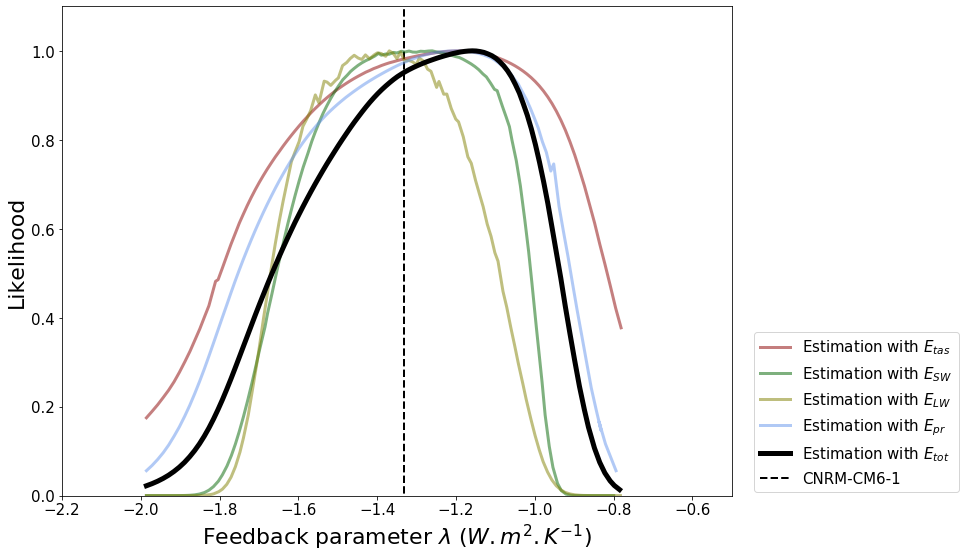

In [44]:
ax = plt.gca()



Likelihood_df.plot(kind='line', x='Fdbck_tas', y='Fdbck_likelihood_tas', color = 'darkred', 
         linewidth=3, figsize=(12, 9), alpha=0.5, ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_SW', y='Fdbck_likelihood_SW', color = 'darkgreen', 
         linewidth=3, alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_LW', y='Fdbck_likelihood_LW', color = 'olive', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_pr', y='Fdbck_likelihood_pr', color = 'cornflowerblue', 
         linewidth=3,  alpha=0.5,ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_total', y='Fdbck_likelihood_total', color = 'black', 
         linewidth=5,  ax = ax)

plt.vlines(p1_feedbacks,ymin = -1000,ymax = 1000,label='default simulation', colors='black', linewidth=2,
           linestyles='dashed')

#color_list = ['pink', 'orange', 'brown', 'green', 'gray', 'blue', 'red']
#for i in range(1, len(Fdbck_CFMIP), 1) :

#    plt.vlines(Fdbck_CFMIP[i],ymin = -1000,ymax = 1000, colors= color_list[i],  linewidth=1.0,
#           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = [ 'Estimation with $E_{tas}$', 'Estimation with $E_{SW}$', 'Estimation with $E_{LW}$', 
          'Estimation with $E_{pr}$', 'Estimation with $E_{tot}$',
                   'CNRM-CM6-1']

#for i in CFMIP_list :
#    legend.append(i)

plt.xlabel('Feedback parameter $\lambda$ ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('Likelihood', fontsize=22)
plt.legend(legend, fontsize=15, bbox_to_anchor=(1.35, 0.35))
#plt.title('Feedbacks likelihood', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.0,1.1)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/Feedback_likelihood.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
# now compute integral cutting right limit down by one
# with each iteration, stop as soon as we hit percplt.show()

In [50]:
### -- Cumulative density function 
def perc_cumul(df, x_str, y_str, q) :
    tmp=0
    L_cumul=[]
    for i in df[y_str] :
        tmp = tmp+i 
        L_cumul.append(tmp)
    df['L_cumul'] = L_cumul
    scale = df['L_cumul'].max()
    df['L_cumul_norm'] = df['L_cumul']/scale

    ## -- Find the percentile 
    cpt=0
    for i in df['L_cumul_norm'] :
        if i>=q/100 :
            perc = df[x_str][cpt]
            L_perc = df[y_str][cpt]
            L_cumul = df['L_cumul_norm'][cpt]
            break
        cpt+=1
    return([perc, L_perc, L_cumul])


In [51]:
perc10 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=10)[0]
L_perc10 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=10)[2]
perc50 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[0]
L_perc50 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[2]
perc90 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=90)[0]
L_perc90 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=90)[2]
print(perc10, perc50, L_perc50, perc90)

-1.648497088978816 -1.2983782731438485 0.5045092228416712 -1.0085390153817002


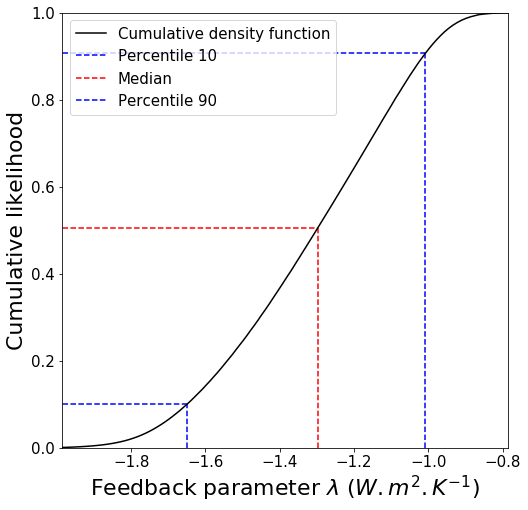

In [57]:
## -- Plot
ax = plt.gca()
Likelihood_df.plot('Fdbck_total', 'L_cumul_norm', color='black', figsize=(8,8), ax=ax)

plt.vlines(perc10, 0, L_perc10, color='blue', linestyle='dashed')
plt.hlines(L_perc10, -2.2, perc10, color='blue', linestyle='dashed', label='_nolegend_')

plt.vlines(perc50, 0, L_perc50, color='red', linestyle='dashed')
plt.hlines(L_perc50, -2.2, perc50, color='red', linestyle='dashed', label='_nolegend_')

plt.vlines(perc90, 0, L_perc90, color='blue', linestyle='dashed')
plt.hlines(L_perc90, -2.2, perc90, color='blue', linestyle='dashed', label='_nolegend_')

## -- Legend 
legend = [ 'Cumulative density function', 'Percentile 10', 'Median', 
          'Percentile 90']
plt.legend(legend, fontsize=15)

## -- Axes label and ticks
plt.xlabel('Feedback parameter $\lambda$ ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('Cumulative likelihood', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=15)

## -- Limits
plt.ylim(0.0,1.0)
#plt.xlim(-2.2,-0.5)

### -- Save or show
plt.show()

In [58]:
perc10 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=10)[0]
L_perc10 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=10)[1]
perc50 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[0]
L_perc50 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[1]
perc90 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=90)[0]
L_perc90 = perc_cumul(Likelihood_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=90)[1]
print(perc10, perc50, L_perc50, perc90)

-1.648497088978816 -1.2983782731438485 0.9665830487454863 -1.0085390153817002


In [59]:
ECS_perc10 = -6.517/perc10
ECS_perc50 = -6.517/perc50
ECS_perc90 = -6.517/perc90
print(ECS_perc10, ECS_perc50, ECS_perc90)

3.953297851461203 5.01933845844475 6.46182239913993


# Likelihood - candidates CNRM-CM

In [60]:
i='total'
Error = Inter_df['Inter']
Fdbck = Inter_df['Fdbck']
L_Inter_df = pd.DataFrame(Fdbck, columns=['Fdbck'])
#L_Inter_df

In [61]:
 E_p1_tmp = E_p1
L = []
cpt=0
for j in Error :
    tmp =exp(-(j**2)/(2*((sigma_CFMIP)**2)))
    tmp_2 = tmp#/sqrt(OSE)*1/100
    L.append(tmp_2)
    cpt+=1


L_Inter_df['Fdbck_'+i] = Fdbck
L_Inter_df['Fdbck_likelihood_'+i] = L
L_Inter_df

,Fdbck,Fdbck_total,Fdbck_likelihood_total
0,-1.70,-1.70,0.000075
1,-1.69,-1.69,0.000134
2,-1.68,-1.68,0.000233
3,-1.67,-1.67,0.000398
4,-1.66,-1.66,0.000667
...,...,...,...
96,-0.74,-0.74,0.000837
97,-0.73,-0.73,0.000757
98,-0.72,-0.72,0.000684
99,-0.71,-0.71,0.000618


In [62]:
scale = L_Inter_df['Fdbck_likelihood_total'].max()
like=[]
for i in L_Inter_df['Fdbck_likelihood_total'] :
    tmp=i/scale
    like.append(tmp)

L_Inter_df['Fdbck_likelihood_total'] = like
L_Inter_df

,Fdbck,Fdbck_total,Fdbck_likelihood_total
0,-1.70,-1.70,0.001991
1,-1.69,-1.69,0.003533
2,-1.68,-1.68,0.006158
3,-1.67,-1.67,0.010525
4,-1.66,-1.66,0.017625
...,...,...,...
96,-0.74,-0.74,0.022111
97,-0.73,-0.73,0.019990
98,-0.72,-0.72,0.018060
99,-0.71,-0.71,0.016319


In [63]:
## -- Cumulative density function
Inter_perc10 = perc_cumul(L_Inter_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=10)[0]
Inter_perc50 = perc_cumul(L_Inter_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[0]
Inter_L_perc50 = perc_cumul(L_Inter_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=50)[1]
Inter_perc90 = perc_cumul(L_Inter_df, 'Fdbck_total', 'Fdbck_likelihood_total', q=90)[0]
print(Inter_perc10, Inter_perc50, Inter_L_perc50, Inter_perc90)

-1.53 -1.34 0.8598512241903569 -1.06


In [64]:
Inter_ECS_perc10 = -6.517/Inter_perc10
Inter_ECS_perc50 = -6.517/Inter_perc50
Inter_ECS_perc90 = -6.517/Inter_perc90
print(Inter_ECS_perc10, Inter_ECS_perc50, Inter_ECS_perc90)

4.2594771241830065 4.863432835820896 6.14811320754717


## Plot

In [163]:
st = -6.517/Fdbck_PPE_selection[0]
end = -6.517/Fdbck_PPE_selection[19]
print(Fdbck_PPE_selection[0], Fdbck_PPE_selection[19], st,end)

-1.7018287181854248 -0.5988670190175375 3.829410051881574 10.882215572150507


In [66]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
OSE

array(0.24799409)

In [67]:
OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_pr.npy')
OSE

array(0.11426227)

In [164]:
st = -6.517/Fdbck_PPE_selection[3]
end = -6.517/Fdbck_PPE_selection[17]
print(Fdbck_PPE_selection[3], Fdbck_PPE_selection[17], st,end)

-1.5731408596038818 -0.9024846951166788 4.142667810205493 7.2211750905730785


In [69]:
lim_h = E_p1 + sigma_CFMIP
lim_l = E_p1 - sigma_CFMIP

In [70]:
import matplotlib.colors as mcolors
import random

plt_colors = list(mcolors.CSS4_COLORS.keys())
st=30
colors=plt_colors[st:st+23]

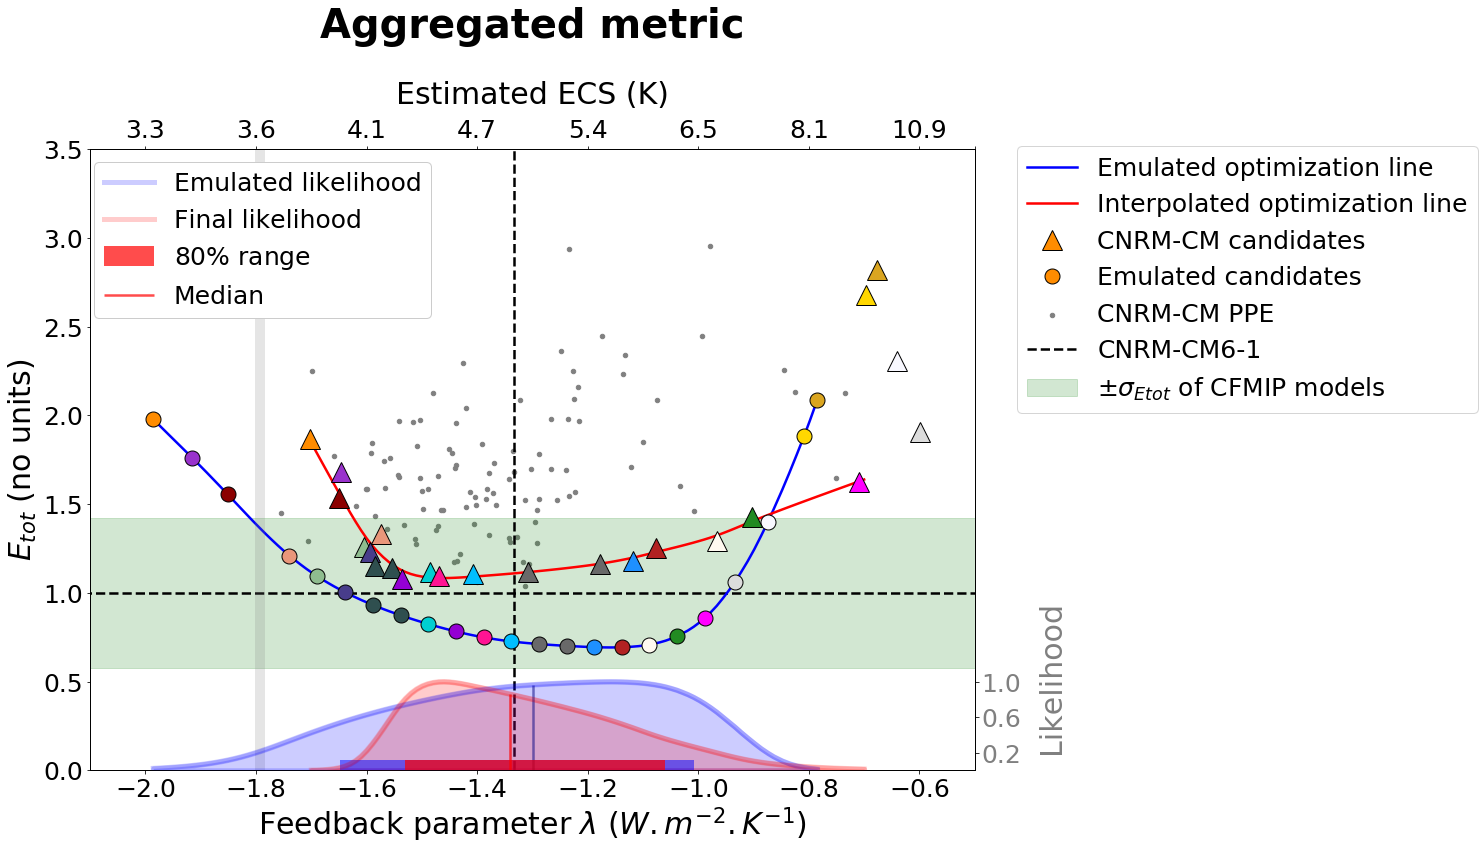

In [77]:
cpt=0

fig = plt.figure(figsize=(15, 12))
ax = plt.gca()
ax2 = ax.twiny()

## -- PPE dots
E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='gray', marker="o", ax = ax)

## -- Emulator optim
sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'blue', 
              alpha=1, linewidth=2.5, ax = ax)
## -- Interpolation optim
Inter_df.plot(kind='line', x='Fdbck', y='Inter', color = 'red', style='-', 
              alpha=1, linewidth=2.5, ax = ax)


for i in colors :
    if cpt == 0 :
        
        ax.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], 
                markerfacecolor=i, color='black', marker='^', 
                linewidth=0, 
                label='ARPEGE-Climat simulations', markersize=20, zorder=10)
        
        ax.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], 
                 markerfacecolor=i, color='black', marker='o', 
                linewidth=0, markersize=15, zorder=10)
        #ax.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, label='$\lambda$ selection',
        #   linestyles='solid', linewidth=1.5)
        cpt+=1
    else :
        plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], 
                 markerfacecolor=i, color='black', marker='o', linewidth=0,
                 markersize=15, label='_nolegend_')
        #plt.vlines(df_select['Fdbck'].iloc[cpt],ymin = -10,ymax = 25, colors=i, 
        #   linestyles='solid', linewidth=1.5)
        
        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], 
                 markerfacecolor=i, color='black', marker='^',
                 linewidth=0, markersize=20, label='_nolegend_', zorder=10)
        #print(cpt)
        cpt+=1
        
plt.vlines(df_crashed['Fdbck'].iloc[0],ymin = -10,ymax = 25, colors='gray', 
           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)
#plt.vlines(df_crashed['Fdbck'].iloc[1],ymin = -10,ymax = 25, colors='gray', 
#           linestyles='solid', alpha=0.2, linewidth=10, zorder=1)

ax.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='ARPEGE-Climat default', colors='black', 
           linestyles='dashed', linewidth=2.5)
ax.fill_between(range(-10, 10, 1), lim_l, lim_h, color='forestgreen', alpha=0.2)

plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

ax.set_xlim(-2.1,-0.5)

## -- Likelihood
ax3 = ax.twinx()
# -- Emulator
plt.hlines(0.0, perc10, perc90, color='blue', linestyle='solid', linewidth=20, 
           label='_nolegend_', alpha=0.5)
plt.vlines(perc50,ymin = 0.0,ymax = L_perc50, 
           colors='navy', alpha=0.5,
           linestyles='solid', linewidth=2.5, label='_nolegend_')
# -- Interpolation
plt.hlines(0.0, Inter_perc10, Inter_perc90, color='red', linestyle='solid', 
           linewidth=20, alpha=0.7)
plt.vlines(Inter_perc50,ymin = 0.0,ymax = Inter_L_perc50, 
           colors='red', alpha=0.7,
           linestyles='solid', linewidth=2.5)

       
ax.set_xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
ax.set_ylabel(ylabel, fontsize=30)
ax.set_xlim(-2.1,-0.5)
ax.set_ylim(0.0,3.5)

plt.title('Aggregated metric', fontsize=40, fontweight='bold', y=1.17)
ax.tick_params(axis='both', which='major', labelsize=25)

#plt.ylim(-0.5,3)

# Second axis

new_tick_locations = np.array([-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.5])#df_select['Fdbck'])
new_tick_locations_ax3 = np.array([ 0.2, 0.6, 1.0])

def tick_function(X):
    V = -6.517/X
    return ["%.1f" % z for z in V]

def tick_function_ax3(X):
    V=X*2
    return ["%.1f" % z for z in V]

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations[:-1]))
ax2.set_xlabel("Estimated ECS (K)", fontsize=30, labelpad=15.0)
ax2.tick_params(axis='both', which='major', labelsize=25)

## -- Likelihood
ax3.set_ylim(0.0,7.0)
ax3.set_yticks(new_tick_locations_ax3)
ax3.set_yticklabels((new_tick_locations_ax3), color='gray')
ax3.set_ylabel("Likelihood", fontsize=30, position=(-0.7, 0.15), labelpad=15.0, color= 'gray')
ax3.tick_params(axis='both', which='major', labelsize=25)

# -- Emulator
Likelihood_df.plot( ax=ax3, x='Fdbck_total', y='Fdbck_likelihood_total', kind='area', 
                   linewidth=5,
                   color='blue', alpha=0.2)
# -- Interpolation
L_Inter_df.plot( ax=ax3, x='Fdbck_total', y='Fdbck_likelihood_total', kind='area', 
                   linewidth=5,
                   color='red', alpha=0.2)

## -- Legend
# -- Main
legend = [ 'Emulated optimization line', 'Interpolated optimization line', 'CNRM-CM candidates', 
          'Emulated candidates', 'CNRM-CM PPE',  
          'CNRM-CM6-1', '$\pm \sigma_{Etot}$ of CFMIP models']
ax.get_legend().remove()
fig.legend(legend, fontsize=25, bbox_to_anchor=(1.38, 0.83)) #bbox_to_anchor=(1.05, 1)
fig.subplots_adjust(right=0.8)
# -- Likelihood
ax3.legend([ 'Emulated likelihood', 'Final likelihood', '$80\%$ range', 'Median'], fontsize=25, 
           bbox_to_anchor=(0.4, 1.0), 
           facecolor='white', framealpha=1.0)


plt.xlim(-2.1,-0.5)


plt.tight_layout()

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable_plot+"_PPE_optim2_select_review.png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [82]:
ax.set_xlim(-2.1,-0.5)
ax.get_xlim()

(-2.1, -0.5)

In [83]:
df_RMSE_selection = pd.DataFrame(E_PPE_selection_total, columns=['E_arpege'])
df_RMSE_selection['E_multilinreg'] = df_select['sol_fun'].data

df_fdbck_selection = pd.DataFrame(Fdbck_PPE_selection, columns=['fdbck_arpege'])
df_fdbck_selection['fdbck_multilinreg'] = df_select['Fdbck'].data
df_fdbck_selection

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


,fdbck_arpege,fdbck_multilinreg
0,-1.701829,-1.985892
1,-1.646602,-1.915792
2,-1.650679,-1.851139
3,-1.573141,-1.739799
4,-1.604805,-1.688818
5,-1.594605,-1.638441
6,-1.584928,-1.588352
7,-1.553765,-1.538515
8,-1.485347,-1.488119
9,-1.535616,-1.438072


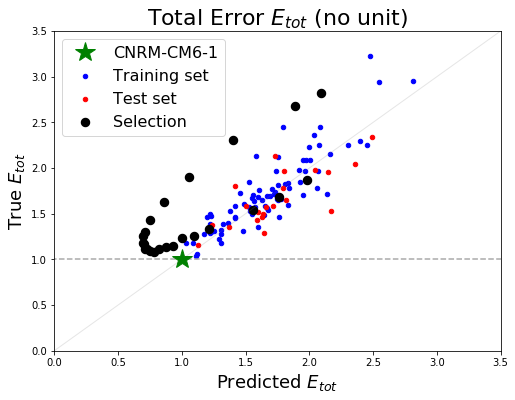

In [99]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"

Validation_RMSE_df[0:80].plot(kind='scatter', y='RMSE_PPE_total', x='RMSE_multilinreg_val_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', y='RMSE_PPE_total', x='RMSE_multilinreg_val_total', color='red',  
                     marker="o", ax = ax)

df_RMSE_selection.plot(kind='scatter', y='E_arpege', x='E_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.plot(1.0, 1.0, color='green', marker='*', 
                 linewidth=0, markersize=20, zorder=10)

ax.hlines(1.0,xmin = -10.0,xmax = 25.0,colors='darkgray', 
           linestyles='dashed', linewidth=1.5)
#ax.vlines(1.0,ymin = -10.0,ymax = 25.0,colors='black', 
#           linestyles='dashed', linewidth=2.5)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['CNRM-CM6-1', 'Training set','Test set','Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,3.5)
plt.xlim(0,3.5)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/test_total_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

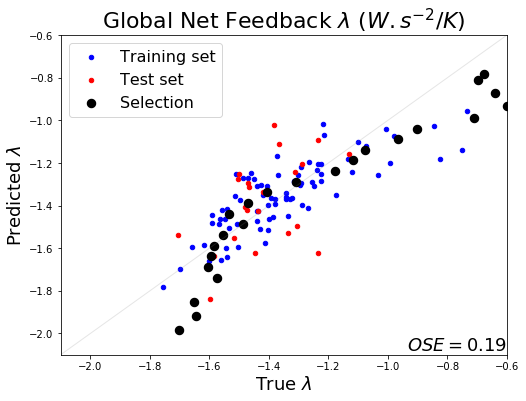

In [100]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)
df_fdbck_selection.plot(kind='scatter', x='fdbck_arpege', y='fdbck_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set', 'Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.1,-0.6)
plt.xlim(-2.1,-0.6)
ax.plot((-4.0,0.6), (-4.0,0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# <a id="param">Parameter analysis</a> </li>

In [27]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")
param_names = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy')
E_emulator_df = E_multilinreg_df.reset_index()

x_emulator = pd.DataFrame(LHS, columns= param_names)
x_emulator['RMSE_total'] = E_emulator_df['RMSE_total']

x_emulator['RMSE_total_round'] = x_emulator['RMSE_total'].round(decimals=1)
x_emulator['members'] = range(0,100000,1) 

#x_emulator = x_emulator.set_index('RMSE_total_round')
#x_emulator_new_df=pd.DataFrame()
#x_emulator_new_df['RMSE_total_best'] = x_emulator['RMSE_total'].groupby('RMSE_total_round').min()
#x_emulator_new_df = x_emulator_new_df.reset_index()
#x_emulator_new_df

In [28]:
x_emulator

,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,RAUTEFS,...,FNEBC,GCTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,REFLCAPE,RMSE_total,RMSE_total_round,members
0,0.237758,1.166405,0.880392,28.558061,-0.013007,5.622351,4.162592,0.003295,0.000736,0.003610,...,5.612146,0.000024,0.753132,0.692837,0.800605,0.649651,2.439231,1.122513,1.1,0
1,0.126381,0.534863,1.789610,28.480600,-0.198482,4.866094,7.643592,0.002512,0.000263,0.002387,...,18.155762,0.000076,0.655943,0.845886,0.712394,0.628513,9.773983,1.394780,1.4,1
2,0.161582,2.774511,1.700513,18.863644,-0.035909,1.940661,1.154684,0.002071,0.000726,0.007475,...,0.206254,0.000061,0.794010,0.880129,0.996989,0.713900,0.379772,1.585584,1.6,2
3,0.269570,0.617033,1.287904,21.638356,-0.425201,1.031540,7.213933,0.006568,0.000110,0.006095,...,16.561323,0.000062,0.920107,0.717110,0.717044,0.901268,9.714537,1.919918,1.9,3
4,0.152002,2.445601,1.837120,17.701181,-0.021411,9.066585,2.859292,0.001732,0.000786,0.004183,...,5.099756,0.000026,0.555454,0.882347,0.915713,0.653554,2.734065,1.289268,1.3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.153543,0.610786,2.065459,14.516229,-0.463268,8.471504,1.785016,0.003410,0.000638,0.001517,...,5.107703,0.000088,0.887371,0.829693,0.874071,0.772201,2.832374,1.574511,1.6,99995
99996,0.097080,2.208875,1.340062,10.473539,-0.304292,3.296326,1.022391,0.002612,0.000963,0.003046,...,17.028286,0.000049,0.527949,0.952927,0.519428,0.923016,2.204335,1.814696,1.8,99996
99997,0.259355,1.213350,1.786574,19.759766,-0.205054,1.078345,7.513847,0.001859,0.000531,0.009371,...,9.389115,0.000087,0.854778,0.778580,0.562029,0.586887,1.455238,1.455482,1.5,99997
99998,0.136834,1.283644,0.691964,9.627438,-0.064111,1.770910,6.090318,0.009920,0.000873,0.007538,...,19.291965,0.000057,0.823763,0.609284,0.856318,0.536784,1.115876,1.532313,1.5,99998


In [29]:
list_param = ['sol_fun', 'feedback']
for i in range(1,31,1) :
    list_param.append('x'+str(i))
#list_param

In [30]:
tmp = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
sol_df_2 = pd.DataFrame(tmp, columns=list_param)
sol_df_2

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,1.978650,-1.985892,0.101214,0.935368,2.308099,29.837961,-0.079678,8.933529,3.065236,0.005121,...,-2.509224,-25.309487,0.074965,14.089843,0.000044,0.911284,0.653104,0.507047,0.534738,6.132308
1,1.934300,-1.971665,0.101923,0.938328,2.290108,28.452721,-0.088391,8.812695,3.234051,0.005073,...,-2.549339,-26.039369,0.076355,14.002736,0.000045,0.903765,0.666056,0.523087,0.543147,5.980319
2,1.890688,-1.957551,0.102680,0.940761,2.272516,27.085657,-0.096932,8.693807,3.398839,0.005022,...,-2.589319,-26.757640,0.077713,13.913016,0.000046,0.896417,0.678766,0.539040,0.551536,5.832291
3,1.847656,-1.943524,0.103436,0.942923,2.254566,25.755345,-0.105087,8.573051,3.560103,0.004973,...,-2.628029,-27.452732,0.079016,13.821948,0.000047,0.889531,0.691275,0.554654,0.559706,5.688266
4,1.804734,-1.929515,0.104246,0.945437,2.235712,24.480462,-0.112664,8.448105,3.717275,0.004923,...,-2.664538,-28.113783,0.080253,13.730112,0.000047,0.883268,0.703476,0.569898,0.567690,5.549150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.677538,-0.835138,0.251033,2.497033,1.288496,23.511310,-0.392016,1.782295,5.319526,0.007066,...,-2.574742,-45.057061,0.018243,7.164023,0.000046,0.571366,0.599374,0.892900,0.885384,6.626445
109,1.778052,-0.822073,0.257232,2.554557,1.254177,24.881865,-0.402303,1.785273,5.539171,0.007239,...,-2.559205,-45.596600,0.018223,7.704046,0.000045,0.560593,0.587080,0.913689,0.894995,6.904529
110,1.884405,-0.808612,0.263653,2.615155,1.219543,26.338284,-0.412717,1.791978,5.772441,0.007417,...,-2.544069,-46.176296,0.018176,8.270878,0.000044,0.549477,0.574530,0.935129,0.905142,7.200580
111,1.972740,-0.797967,0.269891,2.650933,1.176321,27.507121,-0.420415,1.778796,5.940043,0.007548,...,-2.509903,-46.511473,0.018145,8.830086,0.000044,0.540922,0.561021,0.957529,0.910594,7.433596


In [31]:
#x_init1 = pd.DataFrame(x_best, columns=[i+'_init1' for i in param_names])
#x_init1['members'] = range(0, len(x_init1), 1)
#x_init1 = x_init1.set_index('members')

#x_init1

#x_optim1 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_optim1[param_names[i]+'_optim1'] = sol_df['x'+str(j)+'_smth_0']
#x_optim1['members'] = range(0, len(x_init1), 1)
#x_optim1 = x_optim1.set_index('members')
#x_optim1

#x_init2 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_init2[param_names[i]+'_init2'] = new_sol_df['x'+str(j)+'_smth_150']
#x_init2['members'] = range(0, len(x_init1), 1)
#x_init2 = x_init2.set_index('members')
#x_init2

#x_optim2 = pd.DataFrame()
#for i in range(0,len(param_names),1) :
#    j = i+1
#    x_optim2[param_names[i]+'_optim2'] = sol_df_2['x'+str(j)+'_smth_0']
#x_optim2['members'] = range(0, len(x_init1), 1)
#x_optim2 = x_optim2.set_index('members')
#x_optim2

#X = x_optim2 #x_init1.merge(x_optim1, on = ['members']).merge(x_init2, on = ['members']).merge(x_optim2, on = ['members'])
#X['Fdbck'] = sol_df_2['Fdbck']
#X

In [32]:
pd.options.display.float_format = '{:.5f}'.format
sol_df_2['$E_{tot}$'] = sol_df_2['sol_fun'].round(decimals=1)
test = sol_df_2
test

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,$E_{tot}$
0,1.97865,-1.98589,0.10121,0.93537,2.30810,29.83796,-0.07968,8.93353,3.06524,0.00512,...,-25.30949,0.07496,14.08984,0.00004,0.91128,0.65310,0.50705,0.53474,6.13231,2.00000
1,1.93430,-1.97166,0.10192,0.93833,2.29011,28.45272,-0.08839,8.81269,3.23405,0.00507,...,-26.03937,0.07635,14.00274,0.00005,0.90376,0.66606,0.52309,0.54315,5.98032,1.90000
2,1.89069,-1.95755,0.10268,0.94076,2.27252,27.08566,-0.09693,8.69381,3.39884,0.00502,...,-26.75764,0.07771,13.91302,0.00005,0.89642,0.67877,0.53904,0.55154,5.83229,1.90000
3,1.84766,-1.94352,0.10344,0.94292,2.25457,25.75534,-0.10509,8.57305,3.56010,0.00497,...,-27.45273,0.07902,13.82195,0.00005,0.88953,0.69127,0.55465,0.55971,5.68827,1.80000
4,1.80473,-1.92952,0.10425,0.94544,2.23571,24.48046,-0.11266,8.44811,3.71727,0.00492,...,-28.11378,0.08025,13.73011,0.00005,0.88327,0.70348,0.56990,0.56769,5.54915,1.80000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.67754,-0.83514,0.25103,2.49703,1.28850,23.51131,-0.39202,1.78229,5.31953,0.00707,...,-45.05706,0.01824,7.16402,0.00005,0.57137,0.59937,0.89290,0.88538,6.62644,1.70000
109,1.77805,-0.82207,0.25723,2.55456,1.25418,24.88187,-0.40230,1.78527,5.53917,0.00724,...,-45.59660,0.01822,7.70405,0.00005,0.56059,0.58708,0.91369,0.89499,6.90453,1.80000
110,1.88440,-0.80861,0.26365,2.61515,1.21954,26.33828,-0.41272,1.79198,5.77244,0.00742,...,-46.17630,0.01818,8.27088,0.00004,0.54948,0.57453,0.93513,0.90514,7.20058,1.90000
111,1.97274,-0.79797,0.26989,2.65093,1.17632,27.50712,-0.42041,1.77880,5.94004,0.00755,...,-46.51147,0.01814,8.83009,0.00004,0.54092,0.56102,0.95753,0.91059,7.43360,2.00000


In [33]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/SIX_Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.7018287181854248,
 -1.6466021140416462,
 -1.6506785949071248,
 -1.5731408596038818,
 -1.6048049926757812,
 -1.5946045716603596,
 -1.584927995999654,
 -1.5537654956181843,
 -1.4853468736012776,
 -1.5356155633926392,
 -1.4691840807596843,
 -1.4072593450546265,
 -1.308760126431783,
 -1.1785019636154175,
 -1.1175294319788616,
 -1.077129324277242,
 -0.9657924969991049,
 -0.9024846951166788,
 -0.7098463575045267,
 -0.5988670190175375,
 -0.6410051385561625,
 -0.6962807377179464,
 -0.6759957869847616]

In [34]:
x_select = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select2.npy')
x_select_df = pd.DataFrame(x_select, columns = list_param).drop([2])
x_select_df['feedback_runs'] = Fdbck_PPE_selection
x_select_df

,sol_fun,feedback,x1,x2,x3,x4,x5,x6,x7,x8,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,feedback_runs
0,1.97865,-1.98589,0.10121,0.93537,2.30810,29.83796,-0.07968,8.93353,3.06524,0.00512,...,-25.30949,0.07496,14.08984,0.00004,0.91128,0.65310,0.50705,0.53474,6.13231,-1.70183
1,1.76205,-1.91579,0.10523,0.94631,2.21740,23.27135,-0.11962,8.32644,3.86278,0.00487,...,-28.73555,0.08139,13.63074,0.00005,0.87764,0.71495,0.58486,0.57563,5.42169,-1.64660
3,1.36531,-1.79312,0.11765,0.92578,1.99397,16.53559,-0.14476,6.97902,4.72314,0.00428,...,-32.47679,0.08460,12.15395,0.00005,0.86702,0.78930,0.68723,0.63125,4.68973,-1.65068
4,1.21028,-1.73980,0.12428,0.91409,1.87279,16.16087,-0.13941,6.20223,4.82201,0.00409,...,-33.37719,0.08103,10.92312,0.00005,0.87208,0.79924,0.70442,0.64292,4.47889,-1.57314
5,1.09297,-1.68882,0.12935,0.91673,1.79924,16.22743,-0.13349,5.37626,4.79543,0.00420,...,-33.90403,0.07615,9.49375,0.00006,0.86737,0.79894,0.71068,0.64648,4.21129,-1.60480
6,1.00266,-1.63844,0.13281,0.93795,1.79955,16.19106,-0.12775,4.59326,4.62000,0.00460,...,-33.90041,0.07157,8.14579,0.00006,0.85465,0.79204,0.71874,0.64831,3.98498,-1.59460
7,0.93164,-1.58835,0.13554,0.98863,1.84353,16.18541,-0.11996,3.95030,4.32667,0.00510,...,-33.50386,0.06791,7.00663,0.00006,0.84037,0.77800,0.73150,0.65629,3.89747,-1.58493
8,0.87373,-1.53851,0.13918,1.07312,1.87545,16.45429,-0.10999,3.47379,4.06861,0.00548,...,-33.08456,0.06449,6.01691,0.00006,0.82956,0.75809,0.74296,0.67338,3.92009,-1.55377
9,0.82422,-1.48812,0.14387,1.17030,1.86391,16.80326,-0.10164,3.13309,3.97524,0.00561,...,-32.86785,0.06004,5.17939,0.00006,0.82472,0.73691,0.74971,0.69452,4.01321,-1.48535
10,0.78241,-1.43807,0.14882,1.24324,1.81610,16.93848,-0.10128,2.90772,4.02753,0.00551,...,-32.88750,0.05373,4.56931,0.00006,0.82734,0.71861,0.75462,0.71107,4.19854,-1.53562


In [35]:
r = np.corrcoef(x_select_df['feedback'], x_select_df['x1'])
r[0,1].round(decimals=2)

0.94

In [36]:
from matplotlib.axis import Axis

def plot_param(df, param_y, p1_feedback, p1_params, xlabel, ylabel, hue, colors, colors_select,
               param_names, xlim_y, ax):
    
    r = np.corrcoef(x_select_df['feedback'], x_select_df[param_y])[0,1].round(decimals=2)
    
    sns.scatterplot(data=df, x="feedback", y=param_y, hue=hue, legend = 'full', 
                    palette=colors, s=100, linewidth=0, ax=ax)
    
    plt.plot(p1_feedbacks, p1_params[ylabel], color='black', marker='+', linewidth=0, 
             markersize=50)
    
    cpt=0
    #for i in colors_select :
    
    #    ax.plot(x_select_df['feedback_runs'][cpt], x_select_df[param_y][cpt], markerfacecolor=i, 
    #            marker='^', 
    #            linewidth=0, label='_nolegend_', markersize=20, 
    #            markeredgecolor='black', zorder=10)
    #    cpt+=1
        
    plt.text(1,0,r'$r= $'+str(r),horizontalalignment='right',
             verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
    
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel(ylabel, fontsize=22)
    #plt.legend(legend, fontsize=15)
    #plt.title('Param 1 et 2', fontsize=30)
    #ax.legend([None])

    plt.legend(markerscale=2)
    ax.get_legend().remove()
    formatter = ticker.FormatStrFormatter('%.1E')
    Axis.set_major_formatter(ax.yaxis, formatter)
    ax.tick_params(axis='both', which='major', labelsize=17)
    plt.xlim(-2.2,-0.5) 
    lim_min = xlim_y[0]-(xlim_y[1]/10)
    lim_max = xlim_y[1]+(xlim_y[1]/10)
        
    plt.ylim(lim_min,lim_max)

    # Show la figure .................
    #plt.show()

In [37]:
# READ FROM ROMAIN REF NAMELIST 

p1_params = {}
p1_params['AKN'] = 0.126
p1_params['ALPHAT'] = 1.13
p1_params['ALD'] = 1.18
p1_params['ALMAVE'] = 10.0
p1_params['AGREF'] = -0.36
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0002
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.00006
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params', p1_params)
#p1_params

In [38]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

<Figure size 432x288 with 0 Axes>

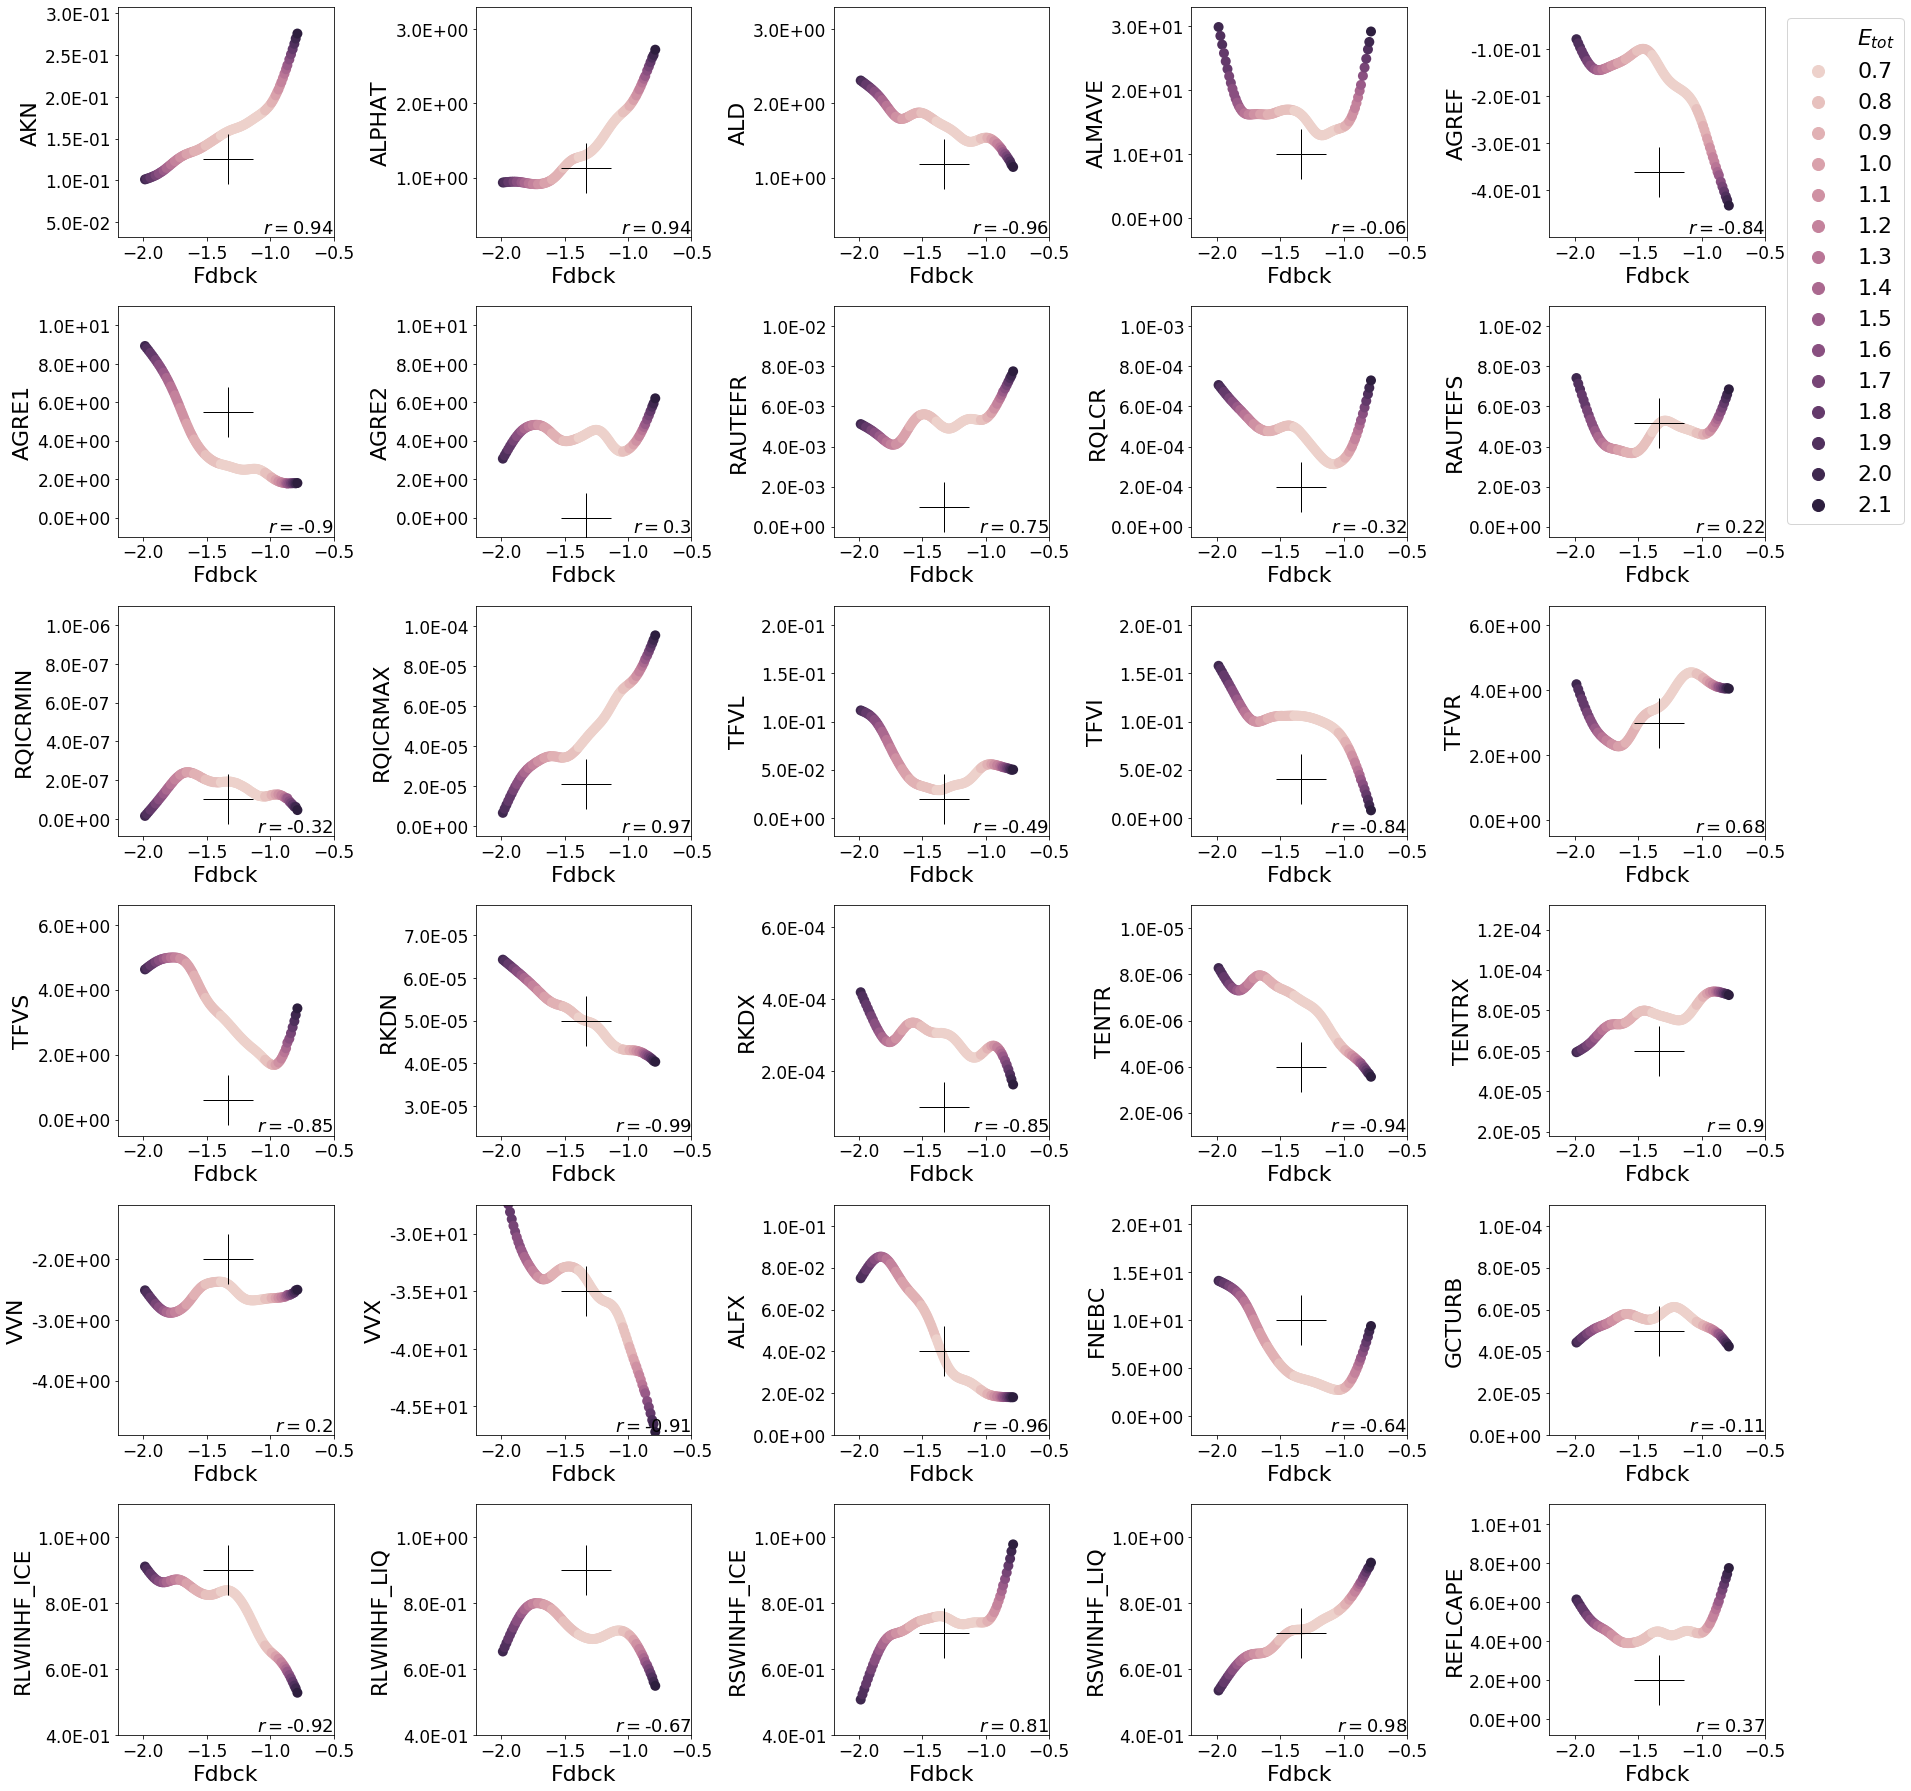

In [153]:
df=sol_df_2
hue = df['$E_{tot}$']
legend = df['$E_{tot}$']
xlabel = 'Fdbck'
colors = plt.summer()
st=30
plt_colors = list(mcolors.CSS4_COLORS.keys())
colors_select = plt_colors[st:st+23]
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

plt.subplots(figsize=(25,25))
ax={}

for i in range(0, 30, 1) :
    
    plt.subplot(6,5,(i+1))
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    xlim_y = xlim[i]
    plot_param(df, param_y, p1_feedbacks, p1_params, xlabel, ylabel, hue, colors, 
               colors_select, param_names, xlim_y, ax[str(i)])
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 7.5), loc=2, markerscale=2)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [40]:
# FONCTIONS FEEDBACKS

def em_fdb_std_coeffs() :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs_std = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    #tmp = Coeffs.values*x
    #y_pred = tmp.sum()+R
    
    return Coeffs_std

In [41]:
Coeffs = em_fdb_std_coeffs()
Coeffs_df=pd.DataFrame(Coeffs)
Coeffs_df['abs'] = abs(Coeffs_df[0])
Coeffs_df = Coeffs_df.sort_values('abs', ascending=False)
Coeffs_df

,0,abs
ALFX,-0.07712,0.07712
TFVS,-0.04990,0.04990
ALPHAT,0.04853,0.04853
RQICRMAX,0.04766,0.04766
AKN,0.03675,0.03675
RSWINHF_LIQ,0.03520,0.03520
RKDN,-0.03411,0.03411
AGRE1,-0.03316,0.03316
RAUTEFS,-0.02392,0.02392
VVX,-0.02020,0.02020


In [42]:
param_names

0             AKN
1          ALPHAT
2             ALD
3          ALMAVE
4           AGREF
5           AGRE1
6           AGRE2
7         RAUTEFR
8           RQLCR
9         RAUTEFS
10       RQICRMIN
11       RQICRMAX
12           TFVL
13           TFVI
14           TFVR
15           TFVS
16           RKDN
17           RKDX
18          TENTR
19         TENTRX
20            VVN
21            VVX
22           ALFX
23          FNEBC
24         GCTURB
25    RLWINHF_ICE
26    RLWINHF_LIQ
27    RSWINHF_ICE
28    RSWINHF_LIQ
29       REFLCAPE
Name: 0, dtype: object

In [43]:
df=sol_df_2
hue = df['$E_{tot}$']
legend = df['$E_{tot}$']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')
st=30
plt_colors = list(mcolors.CSS4_COLORS.keys())
colors_select = plt_colors[st:st+23]
p1_feedbacks = np.load(path_file_npy+'/Net_feedbacks_p1.npy')

plt.subplots(figsize=(20,20))
ax={}

list_strong_param = [16,28,11,2,22,0,1,18,25]

cpt=1

for i in list_strong_param :
    
    plt.subplot(3,3,cpt)
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    xlim_y = xlim[i]
    plot_param(df, param_y, p1_feedbacks, p1_params, xlabel, ylabel, hue, colors, 
               colors_select, param_names, xlim_y, ax[str(i)])
    cpt+=1
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 3.63), loc=2, markerscale=2) #, bbox_to_anchor=(1.05, 7.5), loc=2

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

NameError: name 'mcolors' is not defined